# Corporate Language as a Market Indicator: A Computational Study of Textual Data from S&P 500 Companies ​

## Data Import, Construction, and Cleaning

### Import the libraries 

In [4]:
# Importing necessary libraries for data manipulation, analysis, and visualization
import os
import re
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from scipy import stats
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.patches as mpatches
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, VBox, Button
from IPython.display import display
import pandas as pd
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact, VBox, Button
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ipywidgets as widgets
from ipywidgets import Button, VBox
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score

### Loading the files and Function Definitions

In [5]:
# Path to the folder containing text files
folder_path = 'C:/Users/alfre/OneDrive/Desktop/tesi/pycode/edgar_MgmtDisc'
# Path to the Loughran-McDonald Master Dictionary
lm_dictionary_path = 'C:/Users/alfre/OneDrive/Desktop/tesi/pycode/Loughran-McDonald_MasterDictionary_1993-2023.csv'

# Function to clean text by removing non-alphabetic characters
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Function to load the Loughran-McDonald dictionary and extract positive and negative words
def load_lm_dictionary(dictionary_path):
    lm_dict = pd.read_csv(dictionary_path)
    positive_words = lm_dict[lm_dict['Positive'] != 0]['Word'].str.lower().tolist()
    negative_words = lm_dict[lm_dict['Negative'] != 0]['Word'].str.lower().tolist()
    return set(positive_words), set(negative_words)

# Function to perform sentiment analysis on text
def analyze_sentiment(text, positive_words, negative_words):
    stop_words = set(stopwords.words('english'))
    words = [word for word in clean_text(text).lower().split() if word not in stop_words]
    word_counts = Counter(words)
    total_words = len(words)
    
    positive_score = sum(word_counts[word] for word in positive_words if word in word_counts)
    negative_score = sum(word_counts[word] for word in negative_words if word in word_counts)
    
    sentiment_expressive_count = positive_score + negative_score
    
    if total_words > 0:
        balance = (positive_score - negative_score) / sentiment_expressive_count if sentiment_expressive_count > 0 else 0
        density = sentiment_expressive_count / total_words
        amplification_factor = 10  # Amplification factor to increase the impact of density
        sentiment_score = balance * density * amplification_factor
    else:
        sentiment_score = 0  

    return sentiment_score, word_counts, {word: word_counts[word] for word in positive_words if word in word_counts}, \
           {word: word_counts[word] for word in negative_words if word in word_counts}

# Function to get top n sentiment words
def top_n_sentiment_words(word_counts, positive_word_freq, negative_word_freq, n=20):
    top_words = Counter({word: word_counts[word] for word in positive_word_freq.keys() | negative_word_freq.keys()})
    filtered_words = {word: count for word, count in top_words.items() if word.isalpha()}
    return [(word, count) for word, count in Counter(filtered_words).most_common(n)]

# Function to categorize sentiment score
def categorize_sentiment(score):
    if score > 0.1:
        return 'Positive'
    elif score > 0.05:
        return 'Slightly Positive'
    elif score > -0.05:
        return 'Neutral'
    elif score > -0.1:
        return 'Slightly Negative'
    else:
        return 'Negative'

# Function to count words in text
def count_words(text):
    cleaned_text = clean_text(text)
    words = word_tokenize(cleaned_text)
    return len(words)

# Function to find repeated phrases in text
def find_repeated_phrases(text, n=4):
    cleaned_text = clean_text(text).lower()
    words = word_tokenize(cleaned_text)
    phrases = ngrams(words, n)
    phrase_counts = Counter(phrases)
    return {phrase: count for phrase, count in phrase_counts.items() if count > 1}

# Function to calculate boilerplate percentage
def calculate_boilerplate_percentage(text, repeated_phrases, n=4, relative_threshold=0.01):
    total_words = len(word_tokenize(text))
    total_repeated_words = 0

    for phrase, count in repeated_phrases.items():
        if (count * n) / total_words >= relative_threshold:
            total_repeated_words += count * n

    unique_repeated_words = total_repeated_words / n  
    return (unique_repeated_words / total_words) * 100

# Load the Loughran and McDonald dictionary
positive_words, negative_words = load_lm_dictionary(lm_dictionary_path)

data = []

### Create DataFrame

In [6]:
# Loop through each file in the folder, extract relevant data and perform analysis
for filename in os.listdir(folder_path):
    with open(os.path.join(folder_path, filename), 'r') as file:
        text = file.read()

        # Extracting cik, company and date
        cik = text.split('CIK:')[1].split('\n')[0].strip()
        company_name = text.split('Company Name:')[1].split('\n')[0].strip()
        filing_date = text.split('Filing Date:')[1].split('\n')[0].strip()

        # Perform sentiment analysis
        sentiment_score, word_counts, sorted_positive_word_freq, sorted_negative_word_freq = analyze_sentiment(text, positive_words, negative_words)
        sentiment_category = categorize_sentiment(sentiment_score)

        # Identify key sentiment words and word count
        key_sentiment_words = top_n_sentiment_words(word_counts, sorted_positive_word_freq, sorted_negative_word_freq)
        word_count = count_words(text)

        # Boilerplate analysis
        repeated_phrases = find_repeated_phrases(text)
        boilerplate_percentage = calculate_boilerplate_percentage(text, repeated_phrases)

        # Append all data to the DataFrame list
        data.append([company_name, cik, filing_date, word_count, sentiment_score, sentiment_category, sorted_positive_word_freq, sorted_negative_word_freq, key_sentiment_words, boilerplate_percentage])

# Create the DataFrame
df = pd.DataFrame(data, columns=['Company', 'CIK', 'Date', 'Word Count', 'Sentiment Score', 'Sentiment Category', 'Positive Words', 'Negative Words', 'Key Sentiment Words', 'Boilerplate Percentage'])


### Data Cleaning and Manipulation

In [7]:
# ----- Data Manipulation -----

### Preprocessing Steps

# Data manipulation and cleaning steps

# Check if companies changed their name during the years: CIK, count of unique company names, and the company names themselves
cik_info = df.groupby('CIK')['Company'].agg(['nunique', lambda x: ', '.join(x.unique())])
cik_info.columns = ['Number of Unique Company Names', 'Associated Company Names']

# Filtering to include only those CIKs with more than one unique company name
cik_info = cik_info[cik_info['Number of Unique Company Names'] > 1]
print("CIKs with Multiple Associated Company Names:")
print(cik_info)

# Some companies modified their company name three times during the last 20 years, thus we will use just one
df.loc[df['CIK'] == '320193', 'Company'] = 'APPLE INC'
df.loc[df['CIK'] == '1326801', 'Company'] = 'META PLATFORMS INC'
df.loc[df['CIK'] == '796343', 'Company'] = 'ADOBE INC'
df.loc[df['CIK'] == '356028', 'Company'] = 'CA INC'
df.loc[df['CIK'] == '51143', 'Company'] = 'IBM INC'
df.loc[df['CIK'] == '1002047', 'Company'] = 'NETAPP INC'
df.loc[df['CIK'] == '1018963', 'Company'] = 'ATI INC'
df.loc[df['CIK'] == '1120193', 'Company'] = 'NASDAQ INC'
df.loc[df['CIK'] == '1138118', 'Company'] = 'CBRE GROUP INC'
df.loc[df['CIK'] == '1282266', 'Company'] = 'WINDSTREAM HOLDINGS INC'
df.loc[df['CIK'] == '1521332', 'Company'] = 'APTIV PLC'
df.loc[df['CIK'] == '18926', 'Company'] = 'LUMEN TECHNOLOGIES INC'
df.loc[df['CIK'] == '47111', 'Company'] = 'HERSHEY CO'
df.loc[df['CIK'] == '64803', 'Company'] = 'CVS HEALTH CORP'
df.loc[df['CIK'] == '69499', 'Company'] = 'MYLAN INC'
df.loc[df['CIK'] == '813828', 'Company'] = 'PARAMOUNT GLOBAL'
df.loc[df['CIK'] == '814453', 'Company'] = 'NEWELL BRANDS INC'
df.loc[df['CIK'] == '822416', 'Company'] = 'PULTEGROUP INC MI'
df.loc[df['CIK'] == '87347', 'Company'] = 'SCHLUMBERGER LIMITED NV'
df.loc[df['CIK'] == '883569', 'Company'] = 'FOSSIL GROUP INC'
df.loc[df['CIK'] == '927066', 'Company'] = 'DAVITA INC'
df.loc[df['CIK'] == '935703', 'Company'] = 'DOLLAR TREE INC'
df.loc[df['CIK'] == '945764', 'Company'] = 'DENBURY INC'

# Check if companies changed their name during the years: CIK, count of unique company names, and the company names themselves
cik_info = df.groupby('CIK')['Company'].agg(['nunique', lambda x: ', '.join(x.unique())])
cik_info.columns = ['Number of Unique Company Names', 'Associated Company Names']

# Filtering to include only those CIKs with more than one unique company name
cik_info = cik_info[cik_info['Number of Unique Company Names'] > 1]
print("CIKs with Multiple Associated Company Names:")
print(cik_info)

# Convert the 'Date' column to datetime for easier manipulation
df['Date'] = pd.to_datetime(df['Date'])

# Extract the year from the date for annual trend analysis
df['Year'] = df['Date'].dt.year

# Calculate the total number of unique companies
total_companies = df['Company'].nunique()

# Count the number of companies per year
companies_per_year = df.groupby('Year')['Company'].nunique()

# Create a new column for the ratio
df['Company Presence by Year'] = df['Year'].apply(lambda x: f"{companies_per_year[x]}/{total_companies}")

# Calculate the total number of reports by company over the last 20 years (2004 to 2023)
# Count the occurrences of each CIK and Company combination in the dataframe
report_counts = df.groupby(['CIK', 'Company']).size()

# Create a new column 'Total Reports by Company' which will hold the ratio of actual reports to the possible 20 (years 2004 to 2023)
df['Total Reports by Company'] = df.apply(lambda row: f"{report_counts[(row['CIK'], row['Company'])]}/20", axis=1)

## Exporting to a CSV file
#df.to_csv('output100.csv', index=False)
#
#df=pd.read_csv('output100.csv')


CIKs with Multiple Associated Company Names:
         Number of Unique Company Names  \
CIK                                       
1002047                               2   
1018963                               2   
1120193                               3   
1138118                               2   
1282266                               3   
1326801                               2   
1521332                               2   
18926                                 3   
320193                                2   
356028                                2   
47111                                 2   
64803                                 3   
69499                                 2   
796343                                2   
813828                                4   
814453                                2   
822416                                2   
87347                                 2   
883569                                2   
927066                                2   
935703   

## Explanatory Data Analysis (EDA)

### Correlation between Word Count and Sentiment Score

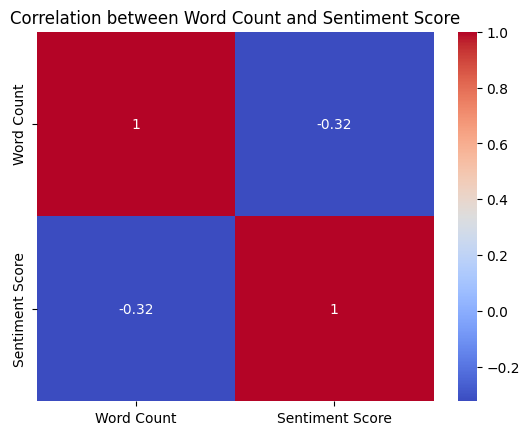

In [8]:
################################################## EDA ################################################

# ------- Calculating the correlation between 'Word Count' and 'Sentiment Score'

# Calculate the correlation between 'Word Count' and 'Sentiment Score'
correlation = df[['Word Count', 'Sentiment Score']].corr()

# Heatmap to visualize the correlation
plt.figure()
sns.heatmap(correlation, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation between Word Count and Sentiment Score')
plt.show()

# Calculate correlation by year
yearly_correlation = df.groupby('Year').apply(lambda x: x[['Word Count', 'Sentiment Score']].corr().iloc[0, 1])

# Reset index to turn the Series into a DataFrame for plotting
yearly_correlation_df = yearly_correlation.reset_index()
yearly_correlation_df.columns = ['Year', 'Correlation']

# Calculate correlation by year
yearly_correlation = df.groupby('Year').apply(lambda x: x[['Word Count', 'Sentiment Score']].corr().iloc[0, 1])

# Reset index to turn the Series into a DataFrame for plotting
yearly_correlation_df = yearly_correlation.reset_index()
yearly_correlation_df.columns = ['Year', 'Correlation']

# Creating an interactive line plot using Plotly
fig = px.line(yearly_correlation_df, x='Year', y='Correlation', 
              title='Yearly Correlation Between Word Count and Sentiment Score',
              markers=True,  
              labels={'Correlation': 'Correlation Coefficient'})

# Add a horizontal line for the average correlation and update layout
average_correlation = -0.32
fig.add_hline(y=average_correlation, line_dash="dot",
              annotation_text=f"Average Correlation: {average_correlation:.2f}", 
              annotation_position="bottom right")

# Customize hover information
fig.update_traces(text='Correlation', hoverinfo='x+y', name='Yearly Correlation')  

# Enhance the visualization with professional details
fig.update_layout(
    plot_bgcolor='white',  
    hovermode='x unified',  
    xaxis_title='Year',
    yaxis_title='Correlation Coefficient',
    xaxis=dict(
        showline=True, 
        showgrid=True,  
        tickmode='linear',
        tick0=df['Year'].min(),
        dtick=1,  
        linecolor='gray', 
        gridcolor='lightgray'  
    ),
    yaxis=dict(
        showline=True,
        showgrid=True,
        linecolor='gray',
        gridcolor='lightgray'
    ),
    legend_title='Legend',
    legend=dict(y=1, x=1, xanchor='right', yanchor='top'),  
    font=dict(  
        family="Arial, sans-serif",
        size=12,
        color="black"
    )
)

fig.write_html('yearly_correlation_plot.html')
fig.show()

### Word Count analysis

#### Word Count Distribution and Trend Over Time

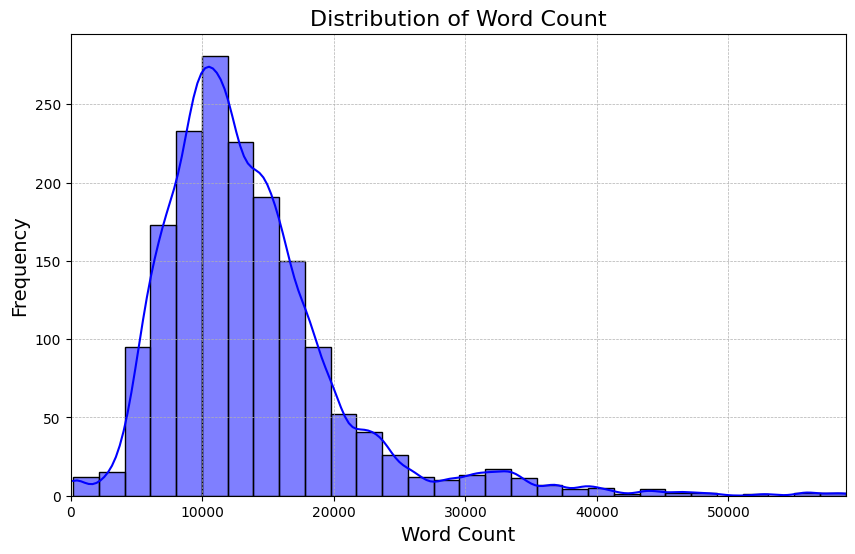

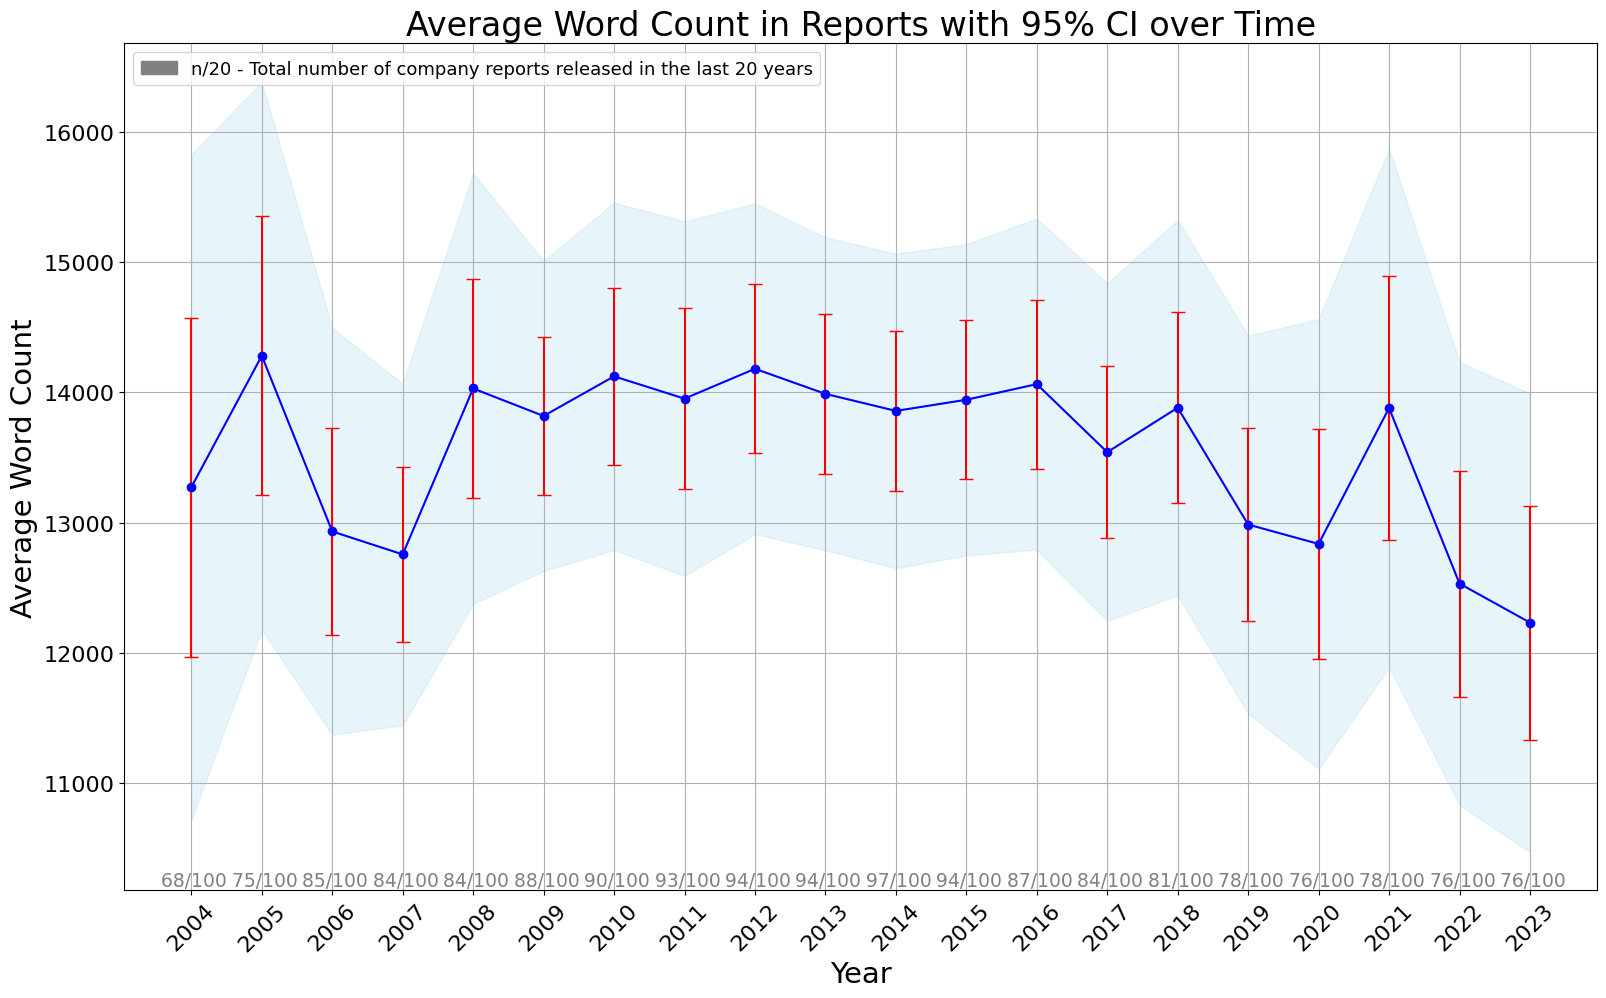

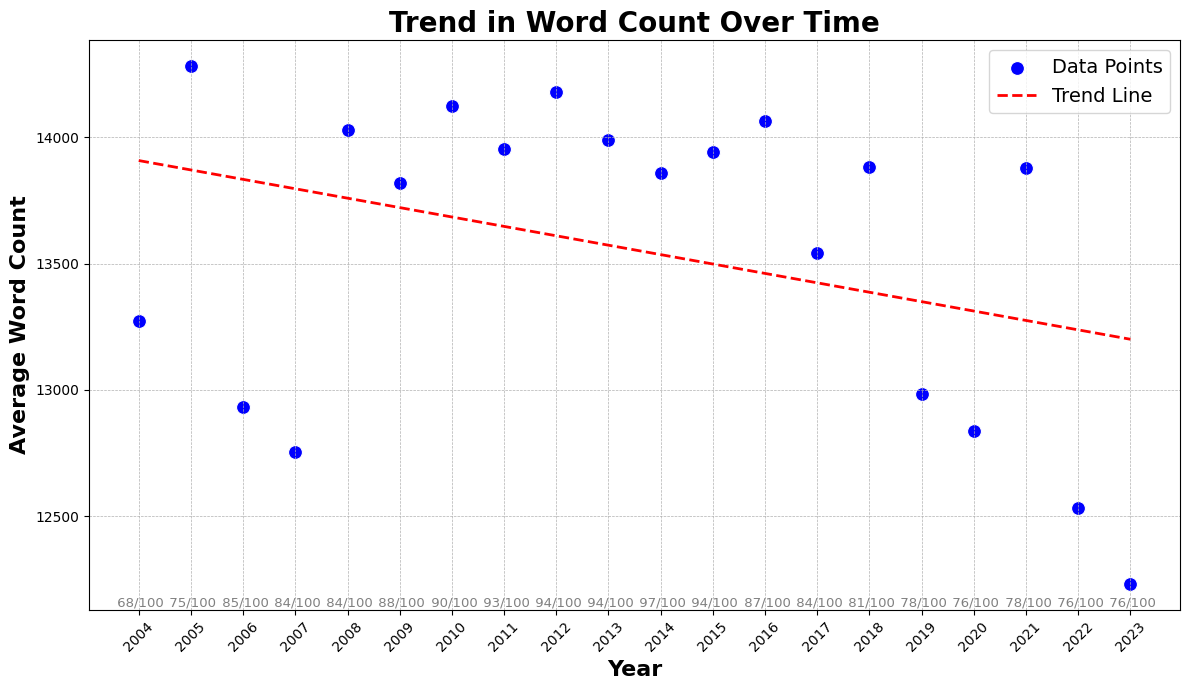

In [9]:
# Creating the plot
plt.figure(figsize=(10, 6))
sns.histplot(df['Word Count'], bins=30, kde=True, color='blue', kde_kws={'bw_adjust':0.5})
plt.title('Distribution of Word Count', fontsize=16)
plt.xlabel('Word Count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(0, df['Word Count'].max())
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# Calculate mean and SEM per year
average_word_count_by_year = df.groupby('Year')['Word Count'].mean().reset_index()
average_word_count_by_year['SEM'] = df.groupby('Year')['Word Count'].sem().reset_index(drop=True)

# Calculate 95% confidence interval
alpha = 0.05  # Significance level for 95% CI
z_score = np.abs(stats.norm.ppf(1 - alpha / 2))  # Critical z-value for 95% CI
ci_half_width = z_score * average_word_count_by_year['SEM']  

# Merge 'Company Presence' data
average_word_count_by_year = average_word_count_by_year.merge(
    df[['Year', 'Company Presence by Year']].drop_duplicates(),
    on='Year',
    how='left'
)

# Graph settings
plt.figure(figsize=(19, 11))

# Mean line and confidence interval
sns.lineplot(
    data=average_word_count_by_year,
    x='Year',
    y='Word Count',
    marker='o',
    color='blue',
    label='Average Word Count'
)
plt.fill_between(
    average_word_count_by_year['Year'],
    (average_word_count_by_year['Word Count'] - ci_half_width),
    (average_word_count_by_year['Word Count'] + ci_half_width),
    alpha=0.2,
    color='skyblue',
    label='95% CI'
)

# SEM bars
plt.errorbar(
    average_word_count_by_year['Year'],
    average_word_count_by_year['Word Count'],
    yerr=average_word_count_by_year['SEM'],
    fmt='o',
    color='blue',
    ecolor='red',
    capsize=5,
    label='SEM'
)

# 'Company Presence' annotations below the x-axis
for i, row in average_word_count_by_year.iterrows():
    plt.text(
        row['Year'],
        plt.gca().get_ylim()[0],
        ' ' + str(row['Company Presence by Year']),
        verticalalignment='bottom',
        horizontalalignment='center',
        color='gray',
        fontsize=13.5
    )

proportion_patch = mpatches.Patch(color='grey', label='n/20 - Total number of company reports released in the last 20 years')
plt.legend(handles=[proportion_patch], loc='upper left', fontsize=13)

# Labels and title
plt.title('Average Word Count in Reports with 95% CI over Time', fontsize=24)
plt.xlabel('Year', fontsize=21)
plt.ylabel('Average Word Count', fontsize=21)
plt.xticks(average_word_count_by_year['Year'], rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)

# Display
plt.show()

# Aggregate data by Year
average_word_count_by_year = df.groupby('Year')['Word Count'].mean().reset_index()
average_word_count_by_year['SEM'] = df.groupby('Year')['Word Count'].sem().reset_index(drop=True)

# Linear Regression to identify trends
X_word = average_word_count_by_year[['Year']]
y_word = average_word_count_by_year['Word Count']
linear_regressor_word = LinearRegression()
linear_regressor_word.fit(X_word, y_word)
trend_line_word = linear_regressor_word.predict(X_word)

# Merge 'Company Presence' data
average_word_count_by_year = average_word_count_by_year.merge(
    df[['Year', 'Company Presence by Year']].drop_duplicates(),
    on='Year',
    how='left'
)

# Plot the trend with detailed visualization
plt.figure(figsize=(12, 7))
sns.scatterplot(x='Year', y='Word Count', data=average_word_count_by_year, s=100, color='blue', label='Data Points')
plt.plot(average_word_count_by_year['Year'], trend_line_word, color='red', linewidth=2, linestyle='--', label='Trend Line')
plt.title('Trend in Word Count Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Average Word Count', fontsize=16, fontweight='bold')
plt.xticks(np.arange(min(average_word_count_by_year['Year']), max(average_word_count_by_year['Year']) + 1, 1), rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 'Company Presence' annotations below the x-axis
for i, row in average_word_count_by_year.iterrows():
    plt.text(
        row['Year'],
        plt.gca().get_ylim()[0],
        ' ' + str(row['Company Presence by Year']),
        verticalalignment='bottom',
        horizontalalignment='center',
        color='gray',
        fontsize=9.5
    )

plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

#### Top Companies by Avg. Word Count

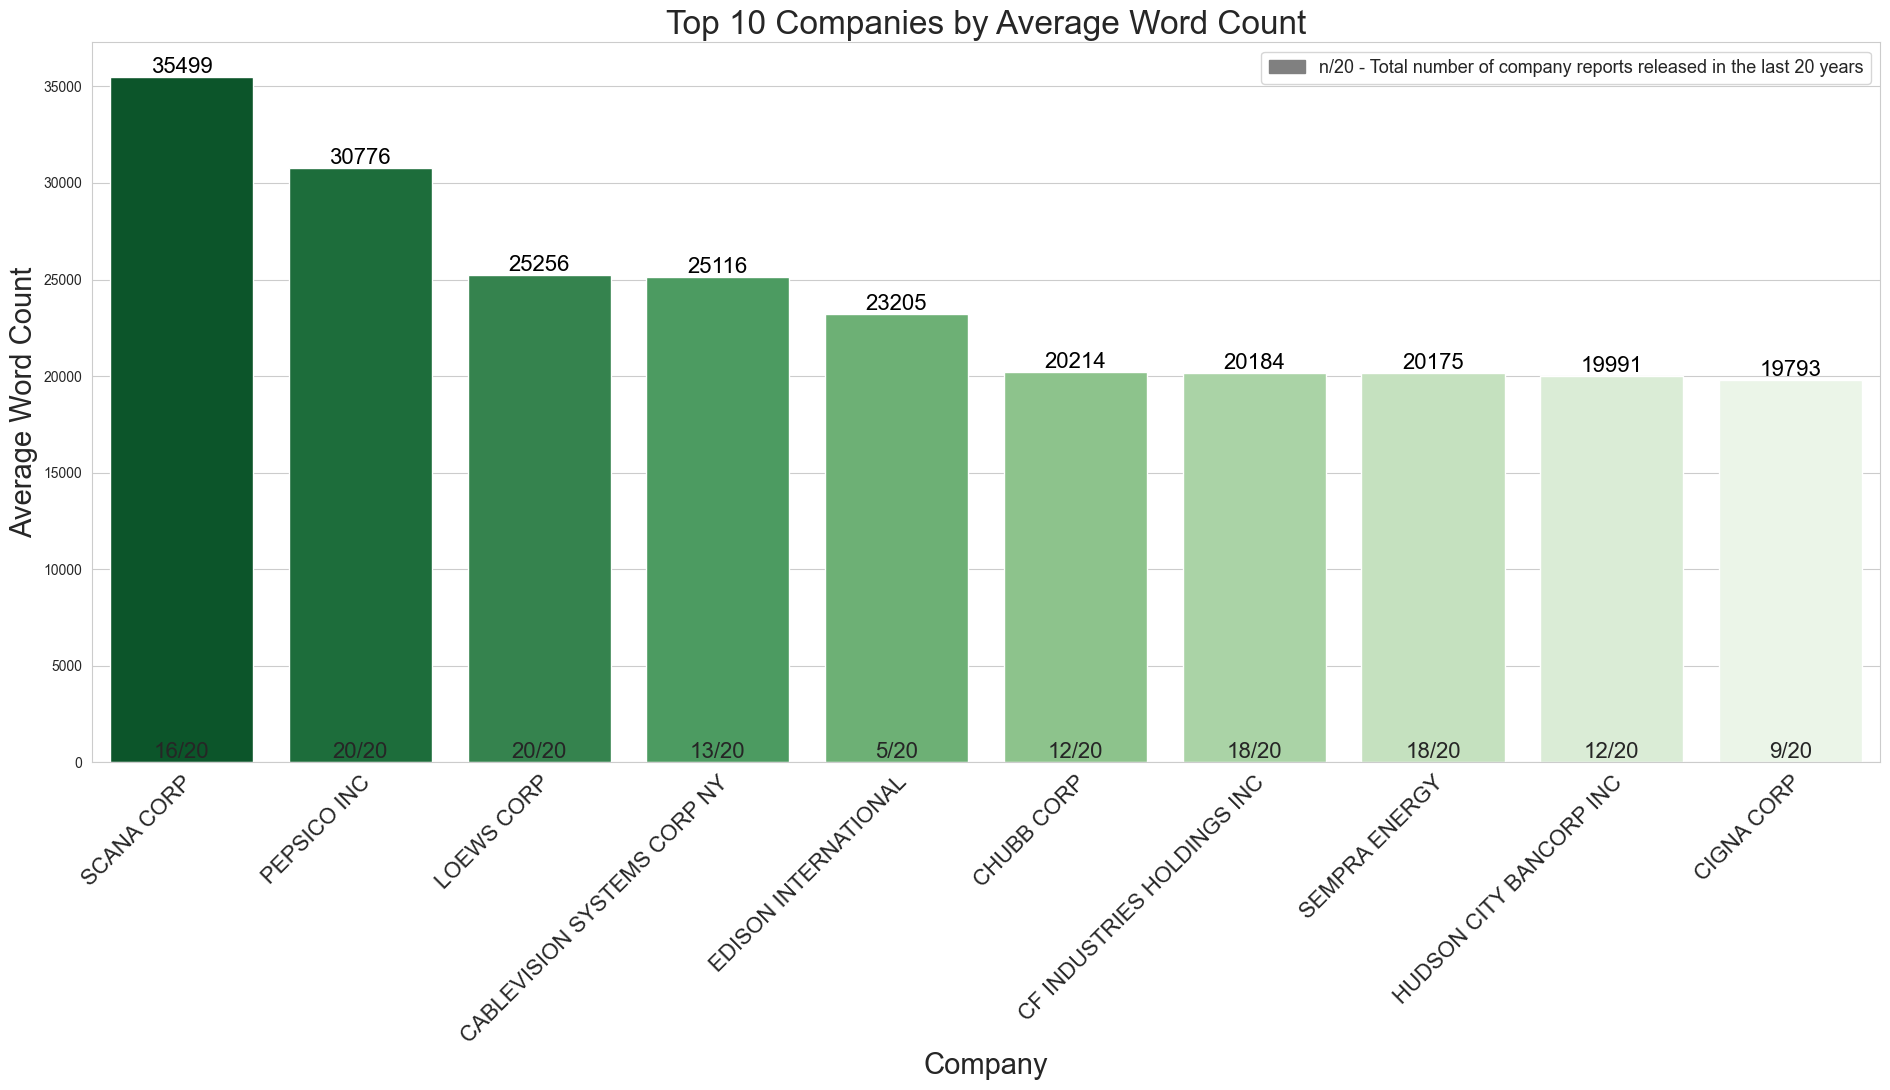

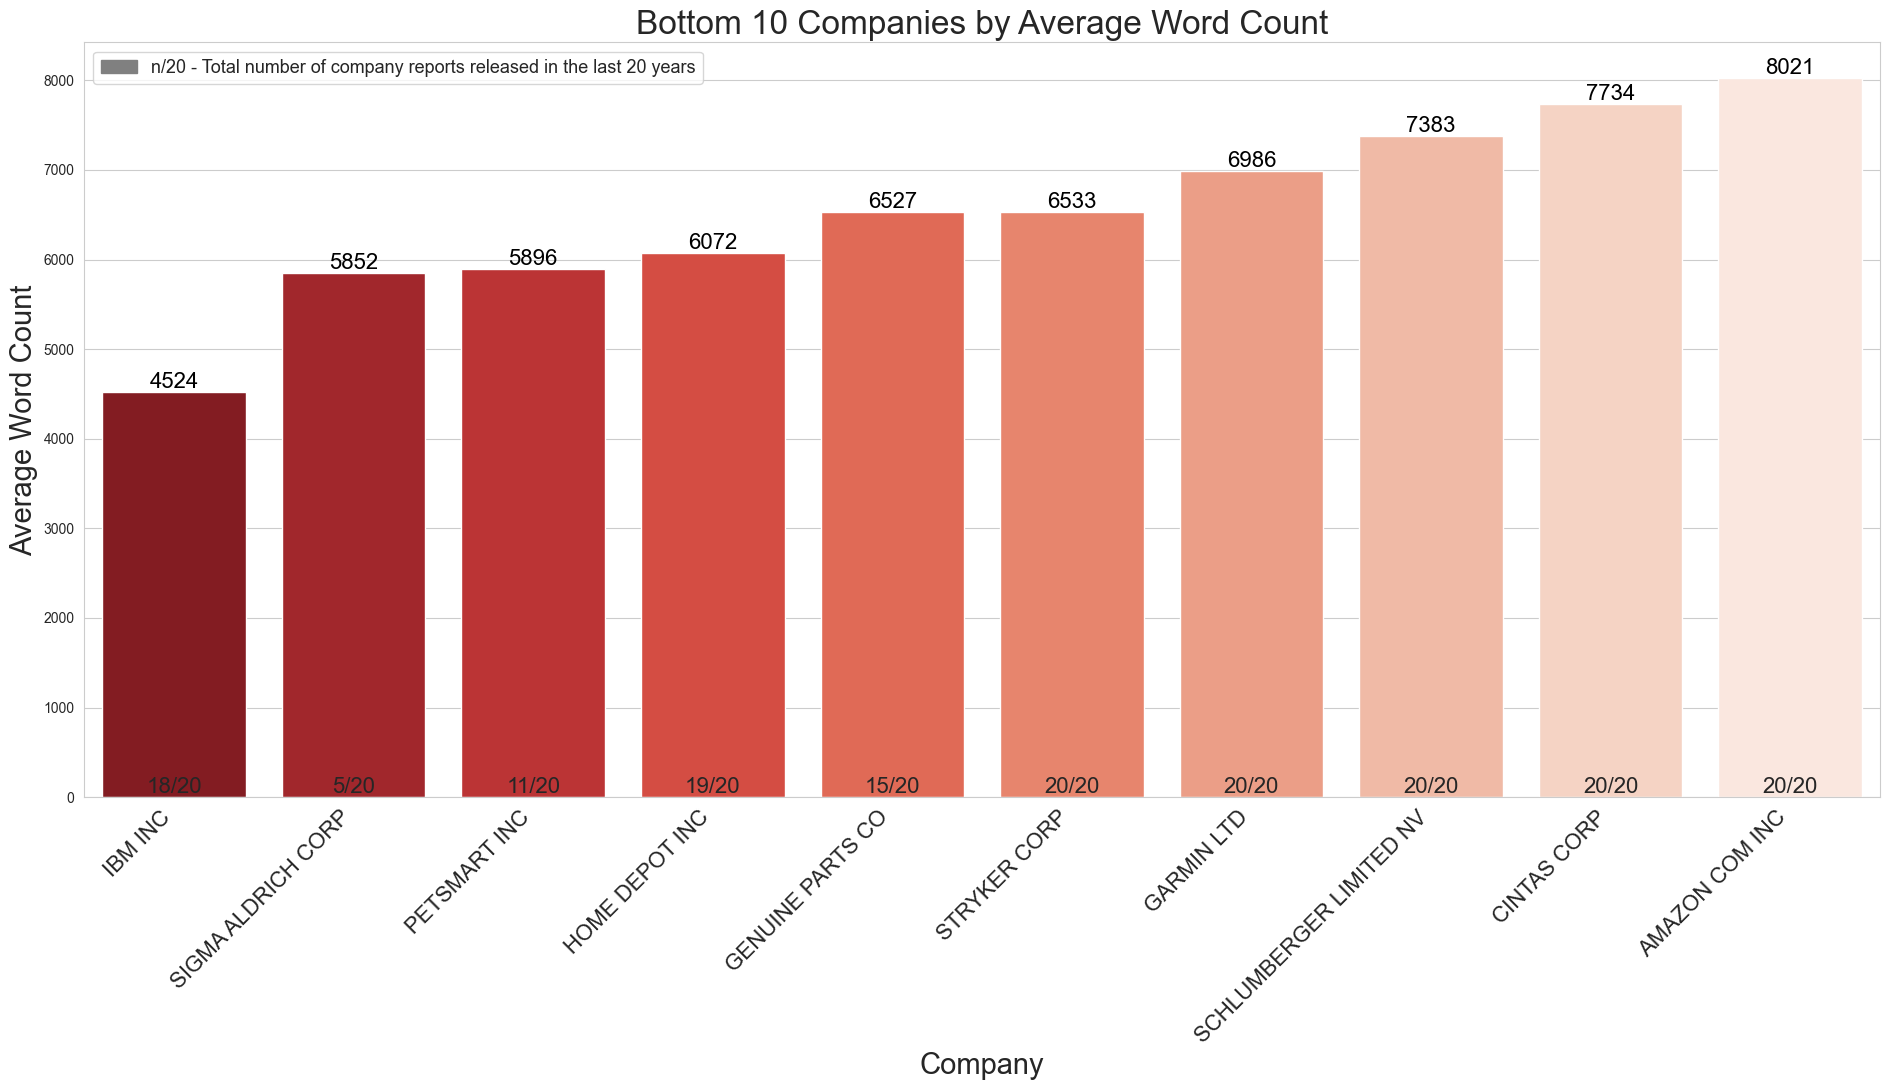

In [10]:
# Identify top 10 companies based on average word count
top_companies_by_word_count = df.groupby('Company')['Word Count'].mean().nlargest(10).index

# Top 10 companies by average word count
top_companies_by_word_count = df.groupby('Company')['Word Count'].mean().nlargest(10).index
top_companies_df = df[df['Company'].isin(top_companies_by_word_count)]

plt.figure(figsize=(19, 11))
sns.set_style("whitegrid")
top_bar = sns.barplot(
    data=top_companies_df,
    x='Company', 
    y='Word Count',
    estimator=np.mean,
    errorbar=None,
    palette='Greens_r',
    order=top_companies_by_word_count
)

# Adjust the position of the company names on the x-axis
top_bar.set_xticklabels(top_bar.get_xticklabels(), rotation=45, horizontalalignment='right', verticalalignment='top', fontsize=16, rotation_mode="anchor")

# Annotating each bar with its value and 'Total Reports by Company'
for index, p in enumerate(top_bar.patches):
    height = p.get_height()
    company_presence = top_companies_df.loc[top_companies_df['Company'] == top_bar.get_xticklabels()[index].get_text(), 'Total Reports by Company'].values[0]
    plt.text(p.get_x() + p.get_width() / 2., height , f'{int(height)}', ha="center", va='bottom', fontsize=16, color='black')
    plt.text(p.get_x() + p.get_width() / 2., -5, f'{company_presence}', ha="center", va='bottom', fontsize=16)

# Legend and title adjustments
proportion_patch = mpatches.Patch(color='grey', label='n/20 - Total number of company reports released in the last 20 years')
plt.legend(handles=[proportion_patch], loc='upper right', fontsize=13)
top_bar.set_title('Top 10 Companies by Average Word Count', fontsize=24)
top_bar.set_xlabel('Company', fontsize=21)
top_bar.set_ylabel('Average Word Count', fontsize=21)
plt.tight_layout()
plt.show()

# Repeat for the bottom 10 companies
bottom_companies_by_word_count = df.groupby('Company')['Word Count'].mean().nsmallest(10).index
bottom_companies_df = df[df['Company'].isin(bottom_companies_by_word_count)]

plt.figure(figsize=(19, 11))
bottom_bar = sns.barplot(
    data=bottom_companies_df,
    x='Company', 
    y='Word Count',
    estimator=np.mean,
    errorbar=None,
    palette='Reds_r',
    order=bottom_companies_by_word_count
)

# Adjust tick labels to prevent overlap
bottom_bar.set_xticklabels(bottom_bar.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=16, verticalalignment='top')

# Annotate each bar with its value and 'Total Reports by Company'
for index, p in enumerate(bottom_bar.patches):
    height = p.get_height()
    company_presence = bottom_companies_df.loc[bottom_companies_df['Company'] == bottom_bar.get_xticklabels()[index].get_text(), 'Total Reports by Company'].values[0]
    plt.text(p.get_x() + p.get_width() / 2., height , f'{int(height)}', ha="center", va='bottom', fontsize=16, color='black')
    plt.text(p.get_x() + p.get_width() / 2., 0, f'{company_presence}', ha="center", va='bottom', fontsize=16)

# Legend and title settings
proportion_patch = mpatches.Patch(color='grey', label='n/20 - Total number of company reports released in the last 20 years')
plt.legend(handles=[proportion_patch], loc='upper left', fontsize=13)
bottom_bar.set_title('Bottom 10 Companies by Average Word Count', fontsize=24)
bottom_bar.set_xlabel('Company', fontsize=21)
bottom_bar.set_ylabel('Average Word Count', fontsize=21)
plt.tight_layout()
plt.show()

#### Top Companies by Average Word Count by Year (Interactive Plot)

In [11]:

# Function to plot data for the selected year
def plot_data(year):
    global fig, ax  # Make fig and ax global variables so they can be accessed by the save function
    # Filter data for the selected year
    filtered_df = df[df['Year'] == int(year)]
    
    # Get top 5 and bottom 5 companies by Word Count
    top_companies = filtered_df.nlargest(5, 'Word Count').sort_values('Word Count', ascending=False)
    bottom_companies = filtered_df.nsmallest(5, 'Word Count').sort_values('Word Count', ascending=False)
    
    # Concatenate top and bottom companies
    combined_df = pd.concat([top_companies, bottom_companies])
    
    # Calculate percentage change from the previous year
    previous_year_df = df[df['Year'] == int(year) - 1]
    combined_df = combined_df.merge(previous_year_df[['Company', 'Word Count']], on='Company', how='left', suffixes=('', '_prev'))
    combined_df['Percentage Change'] = ((combined_df['Word Count'] - combined_df['Word Count_prev']) / combined_df['Word Count_prev'] * 100).fillna(0)
    
    # Assign colors for top and bottom companies for clear visualization
    colors = ['green' if x in top_companies['Word Count'].values else 'red' for x in combined_df['Word Count']]
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 7))
    bars = ax.barh(combined_df['Company'], combined_df['Word Count'], color=colors)
    ax.set_xlabel('Word Count')
    ax.set_title(f'Top and Bottom 5 Companies by Word Count in {year}')
    
    # Annotate each bar with its respective value
    for bar, change in zip(bars, combined_df['Percentage Change']):
        width = bar.get_width()
        label_x_pos = width + 5
        ax.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'{width} ({change:+.2f}%)', va='center')
    
    # Extend x-axis limit to accommodate text
    max_word_count = combined_df['Word Count'].max()
    ax.set_xlim(0, max_word_count * 1.18)

    # Add a legend to differentiate between Top and Bottom companies
    top_bar = plt.Rectangle((0,0),1,1,fc="green", edgecolor = 'none')
    bottom_bar = plt.Rectangle((0,0),1,1,fc='red', edgecolor = 'none')
    ax.legend([top_bar, bottom_bar], ['Top 5 Companies', 'Bottom 5 Companies'], loc='upper right')
    
    plt.show()

# Function to save the plot as PNG
def save_plot(_):
    filename = f'top_bottom_companies_word_count_{year_dropdown.value}.png'
    fig.savefig(filename, format='png')
    print(f'Plot saved as {filename}')

# Dropdown for selecting the year
year_dropdown = widgets.Dropdown(
    options=[str(year) for year in sorted(df['Year'].unique())],
    value=str(sorted(df['Year'].unique())[0]),
    description='Year:',
)

# Save button
save_button = Button(description="Save Plot")
save_button.on_click(save_plot)

# Combine the dropdown and button in a layout
ui = VBox([year_dropdown, save_button])

# Bind the plotting function to the dropdown widget
interact(plot_data, year=year_dropdown)

# Display the UI
display(ui)



interactive(children=(Dropdown(description='Year:', options=('2004', '2005', '2006', '2007', '2008', '2009', '…

#### Word Count Over Time by Company

In [12]:
# Function to plot data for selected companies and save the plot as HTML
def plot_data(selected_companies):
    global fig  
    fig = go.Figure()

    if not selected_companies:
        avg_data = df.groupby('Year')['Word Count'].mean().reset_index()
        fig.add_trace(go.Scatter(
            x=avg_data['Year'],
            y=avg_data['Word Count'],
            mode='lines+markers',
            name='Average Word Count',
            hoverinfo='all'
        ))
        title_text = "Average Word Count Across All Companies"
    else:
        max_word_count = 0
        company_names = []

        for company in selected_companies:
            company_data = df[df['Company'] == company].sort_values('Year')
            current_max = company_data['Word Count'].max()
            if current_max > max_word_count:
                max_word_count = current_max

            fig.add_trace(go.Scatter(
                x=company_data['Year'],
                y=company_data['Word Count'],
                mode='lines+markers',
                name=company,
                hoverinfo='all'
            ))

            company_names.append(company)

        title_text = f"Word Count Time Series for {' & '.join(company_names)}"

    fig.update_layout(
        title=title_text,
        xaxis_title='Year',
        yaxis_title='Word Count',
        legend_title='Company',
        hovermode='closest',
        plot_bgcolor='white',
        xaxis=dict(
            tickmode='linear',
            dtick=1,
            showline=True,
            showgrid=True,
            linecolor='gray',
            gridcolor='lightgray'
        ),
        yaxis=dict(
            showline=True,
            showgrid=True,
            linecolor='gray',
            gridcolor='lightgray'
        ),
        font=dict(
            family="Arial, sans-serif",
            size=12,
            color="black"
        )
    )

    fig.show()

# Function to save the plot
def save_plot(_):
    if not company_dropdown.value:
        filename = 'average_word_count_across_all_companies.html'
    else:
        company_names = '_'.join(company_dropdown.value).replace(' ', '_')
        filename = f'word_count_time_series_for_{company_names}.html'
    fig.write_html(filename)
    print(f'Plot saved as {filename}')

# Dropdown for selecting the company with multiple selections enabled
company_dropdown = widgets.SelectMultiple(
    options=sorted(df['Company'].unique()),
    description='Company:',
    disabled=False
)

# Save button
save_button = Button(description="Save Plot")
save_button.on_click(save_plot)

ui = VBox([company_dropdown, save_button])
interact(plot_data, selected_companies=company_dropdown)

# Display the UI
display(ui)

####### In order to select multiple companies at the same time -> hold CTRL + left mouse click #######


interactive(children=(SelectMultiple(description='Company:', options=('ABBVIE INC', 'ACCENTURE PLC', 'ADOBE IN…

### Sentiment Score Analysis

#### Sentiment Score Distribution and Trend Over Time


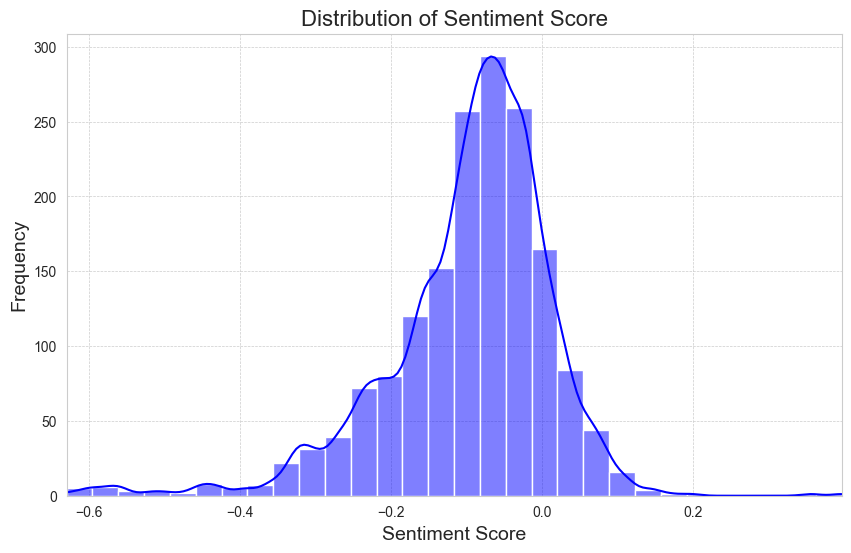

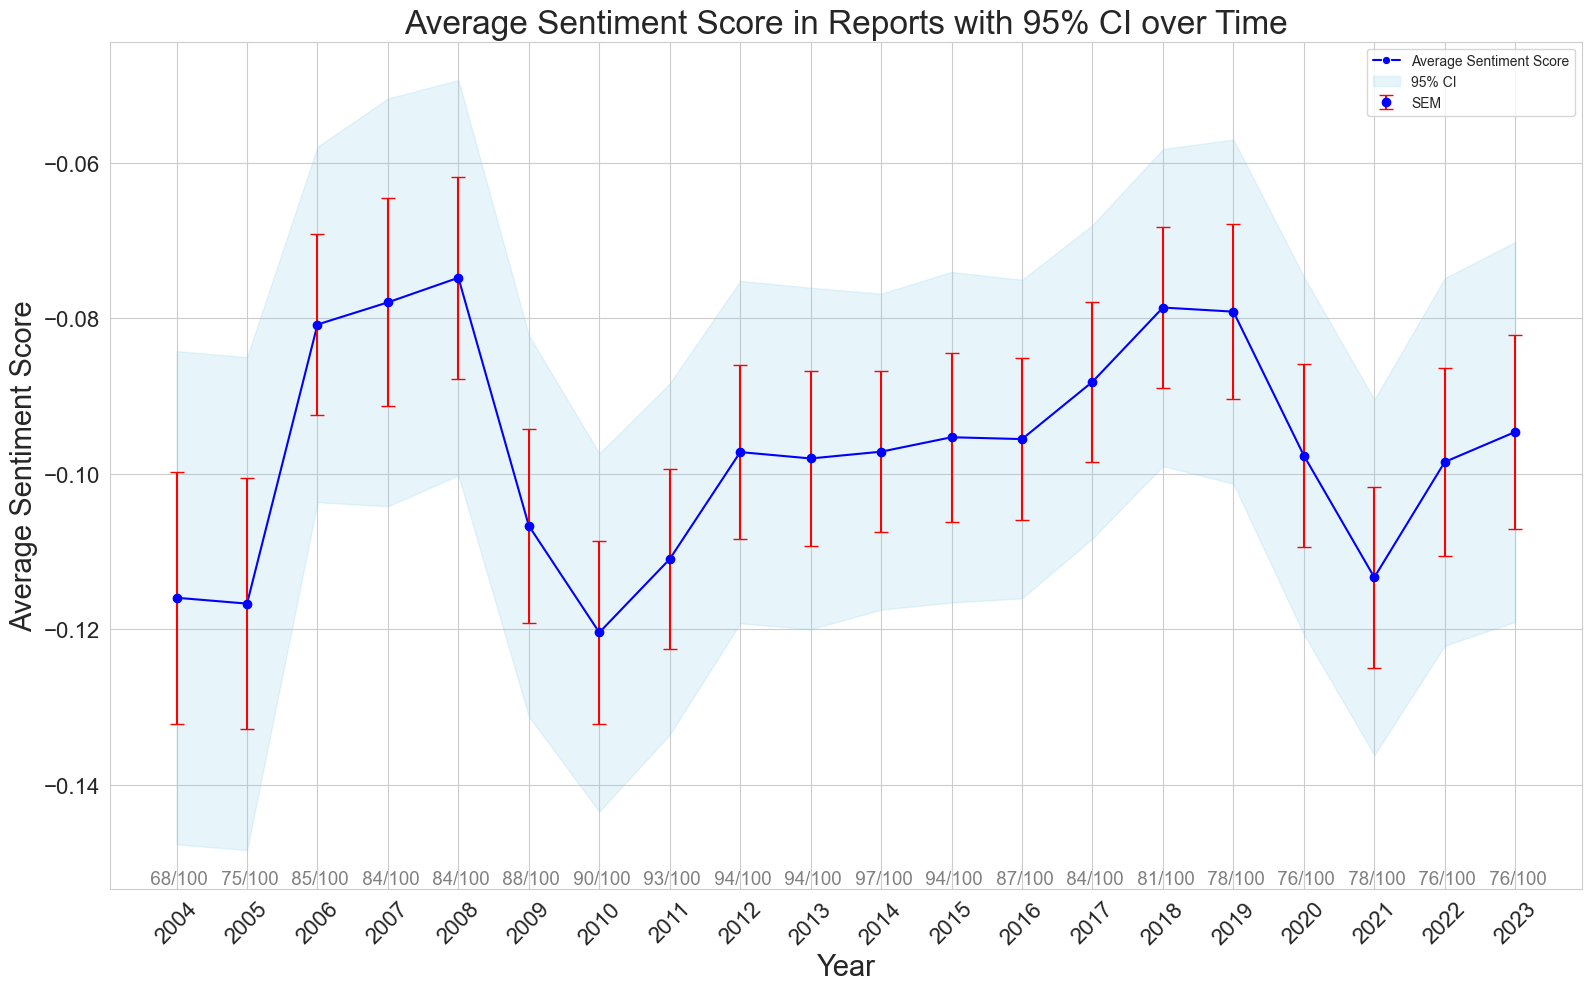

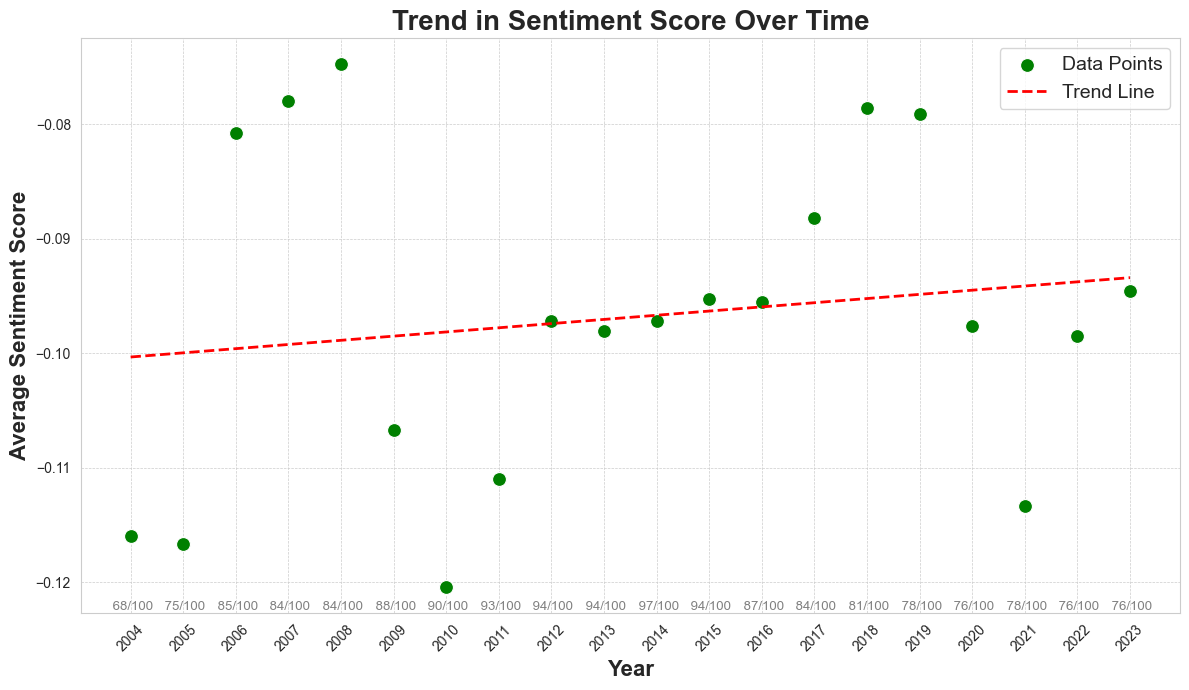

In [13]:
# Creating the plot
plt.figure(figsize=(10, 6))
sns.histplot(df['Sentiment Score'], bins=30, kde=True, color='blue', kde_kws={'bw_adjust':0.5})
plt.title('Distribution of Sentiment Score', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(df['Sentiment Score'].min(), df['Sentiment Score'].max())
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# Calculate mean and SEM per year for Sentiment Score
average_sentiment_by_year = df.groupby('Year')['Sentiment Score'].mean().reset_index()
average_sentiment_by_year['SEM'] = df.groupby('Year')['Sentiment Score'].sem().reset_index(drop=True)

# Calculate 95% confidence interval
alpha = 0.05
z_score = np.abs(stats.norm.ppf(1 - alpha / 2))
ci_half_width = z_score * average_sentiment_by_year['SEM']

# Merge 'Company Presence' data 
average_sentiment_by_year = average_sentiment_by_year.merge(
    df[['Year', 'Company Presence by Year']].drop_duplicates(),
    on='Year',
    how='left'
)

# Graph settings
plt.figure(figsize=(19, 11))

# Mean line and confidence interval
sns.lineplot(
    data=average_sentiment_by_year,
    x='Year',
    y='Sentiment Score',
    marker='o',
    color='blue',
    label='Average Sentiment Score'
)
plt.fill_between(
    average_sentiment_by_year['Year'],
    (average_sentiment_by_year['Sentiment Score'] - ci_half_width),
    (average_sentiment_by_year['Sentiment Score'] + ci_half_width),
    alpha=0.2,
    color='skyblue',
    label='95% CI'
)

# SEM bars
plt.errorbar(
    average_sentiment_by_year['Year'],
    average_sentiment_by_year['Sentiment Score'],
    yerr=average_sentiment_by_year['SEM'],
    fmt='o',
    color='blue',
    ecolor='red',
    capsize=5,
    label='SEM'
)

# 'Company Presence' annotations below the x-axis
for i, row in average_sentiment_by_year.iterrows():
    plt.text(
        row['Year'],
        plt.gca().get_ylim()[0],
        ' ' + str(row['Company Presence by Year']),
        verticalalignment='bottom',
        horizontalalignment='center',
        color='gray',
        fontsize=13.5
    )

# Labels and title
plt.title('Average Sentiment Score in Reports with 95% CI over Time', fontsize=24)
plt.xlabel('Year', fontsize=21)
plt.ylabel('Average Sentiment Score', fontsize=21)
plt.xticks(average_sentiment_by_year['Year'], rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)

# Legend
plt.legend()

# Display
plt.show()

# Aggregate data by Year
average_sentiment_score_by_year = df.groupby('Year')['Sentiment Score'].mean().reset_index()
average_sentiment_score_by_year['SEM'] = df.groupby('Year')['Sentiment Score'].sem().reset_index(drop=True)

# Linear Regression to identify trends
X_sentiment = average_sentiment_score_by_year[['Year']]
y_sentiment = average_sentiment_score_by_year['Sentiment Score']
linear_regressor_sentiment = LinearRegression()
linear_regressor_sentiment.fit(X_sentiment, y_sentiment)
trend_line_sentiment = linear_regressor_sentiment.predict(X_sentiment)

# Merge 'Company Presence' data
average_sentiment_score_by_year = average_sentiment_score_by_year.merge(
    df[['Year', 'Company Presence by Year']].drop_duplicates(),
    on='Year',
    how='left'
)

# Plot the trend with detailed visualization
plt.figure(figsize=(12, 7))
sns.scatterplot(x='Year', y='Sentiment Score', data=average_sentiment_score_by_year, s=100, color='green', label='Data Points')
plt.plot(average_sentiment_score_by_year['Year'], trend_line_sentiment, color='red', linewidth=2, linestyle='--', label='Trend Line')
plt.title('Trend in Sentiment Score Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Average Sentiment Score', fontsize=16, fontweight='bold')
plt.xticks(np.arange(min(average_sentiment_score_by_year['Year']), max(average_sentiment_score_by_year['Year']) + 1, 1), rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 'Company Presence' annotations below the x-axis
for i, row in average_sentiment_score_by_year.iterrows():
    plt.text(
        row['Year'],
        plt.gca().get_ylim()[0],
        ' ' + str(row['Company Presence by Year']),
        verticalalignment='bottom',
        horizontalalignment='center',
        color='gray',
        fontsize=9.5
    )

plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

#### Top companies by Avg. Sentiment Score

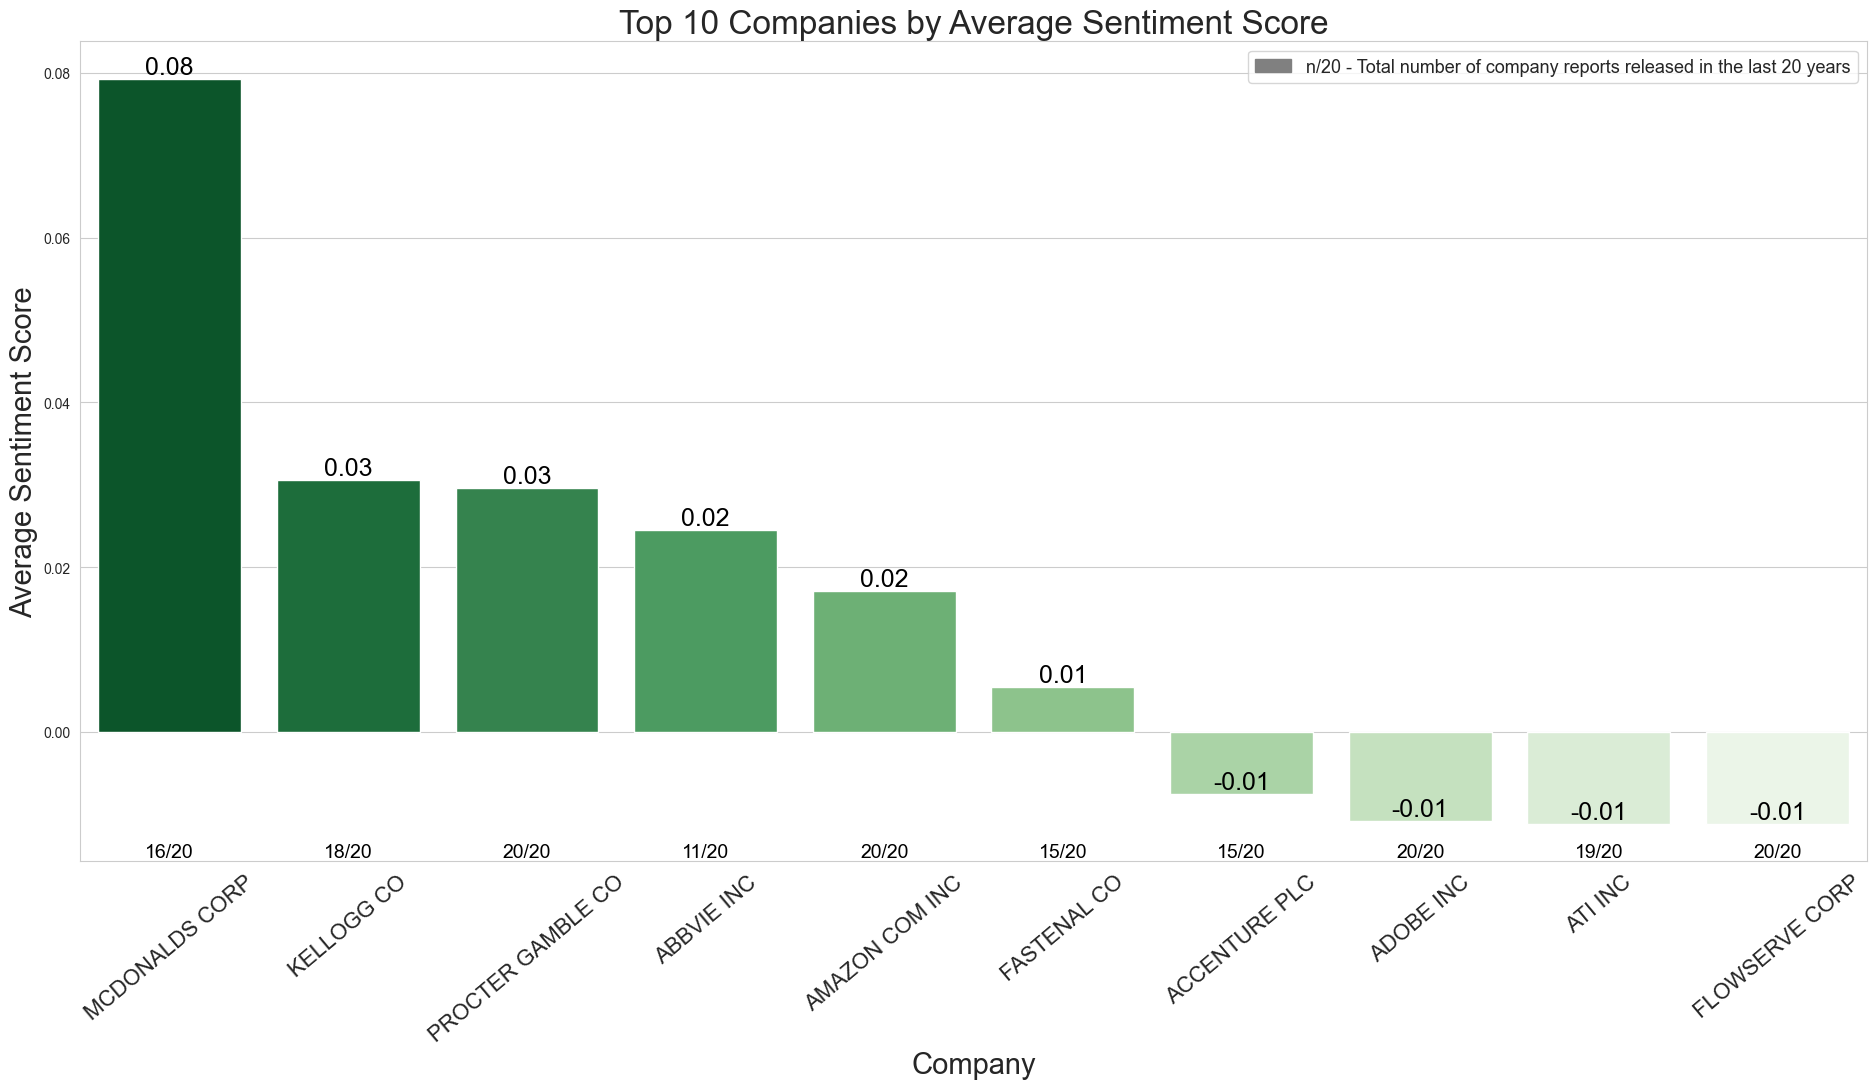

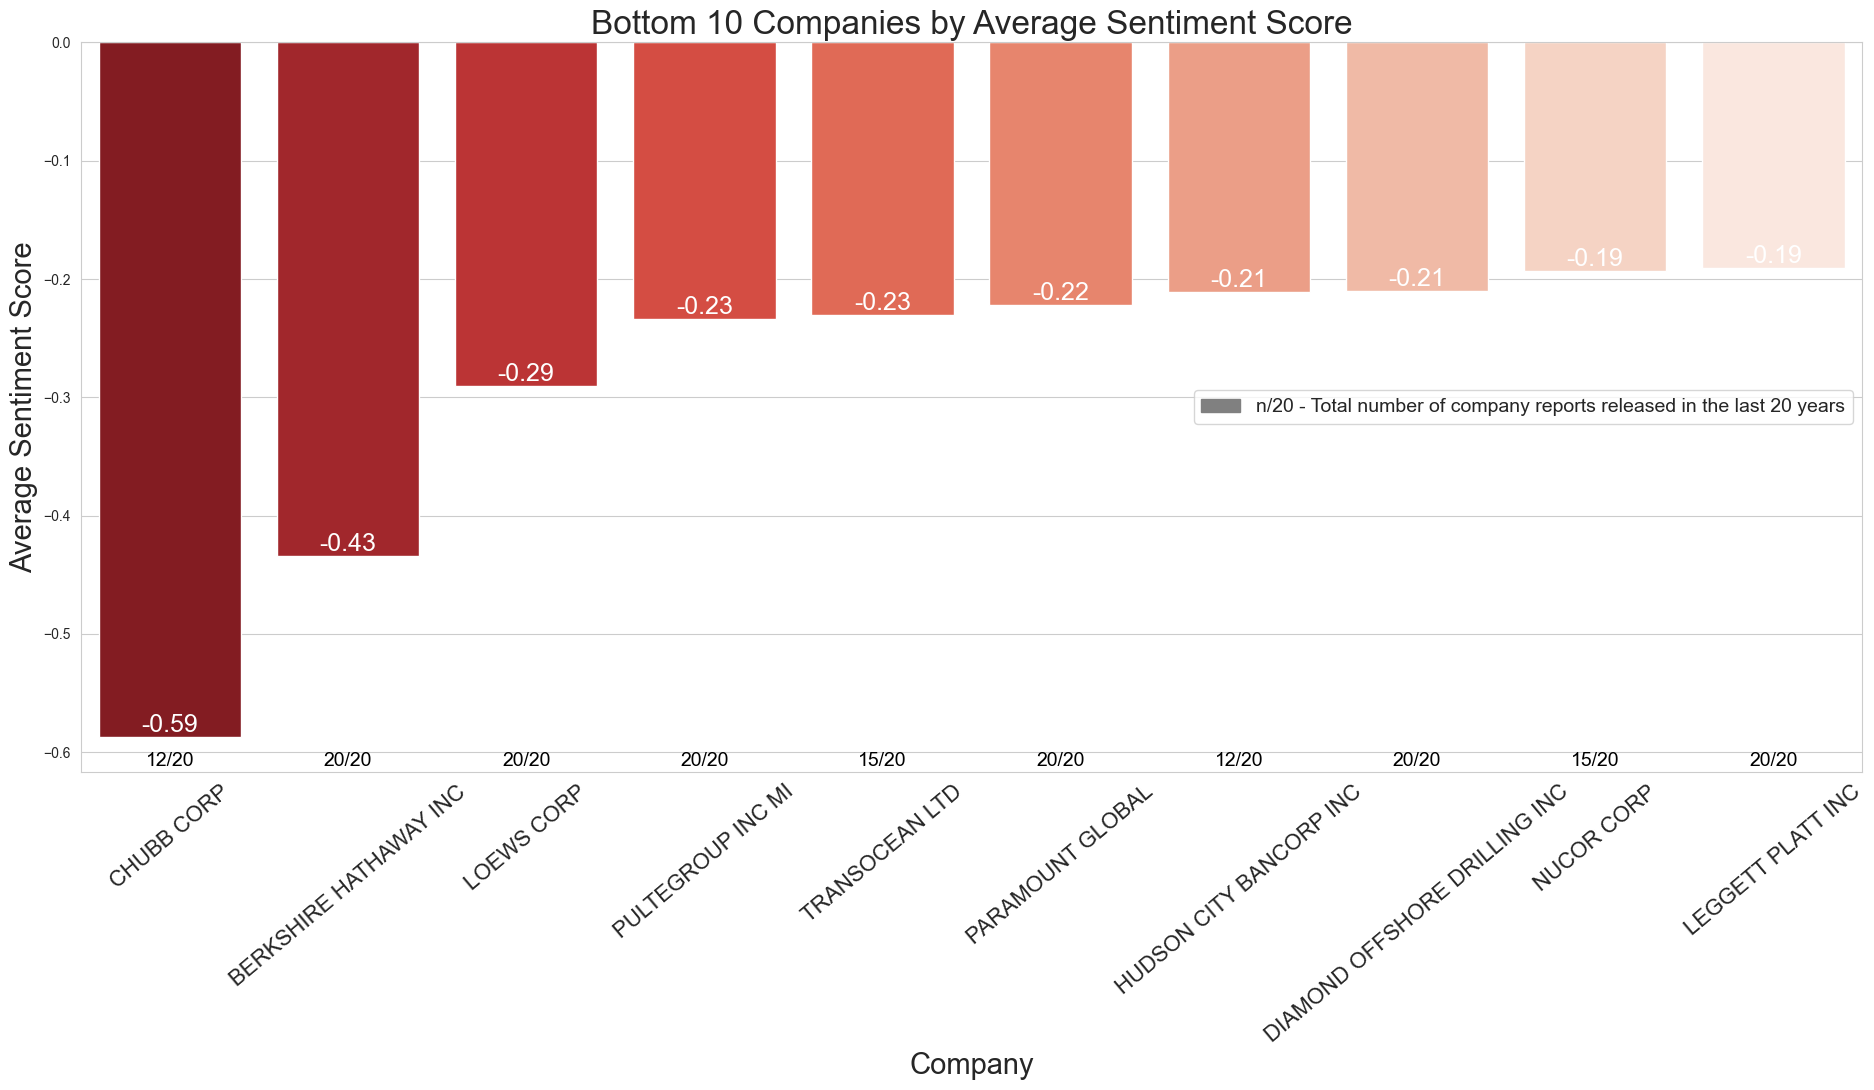

In [14]:
# Grouping data by Company Name and calculating the average word count and sentiment score for each company
company_grouped = df.groupby('Company').agg({'Word Count': 'mean', 'Sentiment Score': 'mean', 'Total Reports by Company': 'first'}).reset_index()

# Sorting to find the top 10 and bottom 10 by Average Sentiment Score
top10_sentiment_score = company_grouped.nlargest(10, 'Sentiment Score')
bottom10_sentiment_score = company_grouped.nsmallest(10, 'Sentiment Score')

# Plot for Top 10 Average Sentiment Score by Company
plt.figure(figsize=(19, 11))
sns.set_style("whitegrid")
top_bar = sns.barplot(x='Company', y='Sentiment Score', data=top10_sentiment_score, palette='Greens_r')
plt.title('Top 10 Companies by Average Sentiment Score', size=24)
plt.xlabel('Company', size=21)
plt.ylabel('Average Sentiment Score', size=21)
plt.xticks(rotation=40, fontsize=16, verticalalignment='top')

# Annotating each bar with its value and 'Total Reports by Company' moved below the company name
for p in top_bar.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height, f'{height:.2f}', ha="center", va='bottom', fontsize=18, color='black')
    company_presence = top10_sentiment_score.loc[top10_sentiment_score['Company'] == top_bar.get_xticklabels()[top_bar.patches.index(p)].get_text(), 'Total Reports by Company'].values[0]
    plt.text(p.get_x() + p.get_width() / 2., -0.0135, f'{company_presence}', ha="center", va='top', fontsize=14, color='black')

plt.tight_layout()
proportion_patch = mpatches.Patch(color='grey', label='n/20 - Total number of company reports released in the last 20 years')
plt.legend(handles=[proportion_patch], loc='upper right', fontsize=13)
plt.show()

# Plot for Bottom 10 Average Sentiment Score by Company
plt.figure(figsize=(19, 11))
bottom_bar = sns.barplot(x='Company', y='Sentiment Score', data=bottom10_sentiment_score, palette='Reds_r')
plt.title('Bottom 10 Companies by Average Sentiment Score', size=24)
plt.xlabel('Company', size=21)
plt.ylabel('Average Sentiment Score', size=21)
plt.xticks(rotation=40, fontsize=16, verticalalignment='top')

# Annotate each bar with its value and 'Total Reports by Company' moved below the company name
for p in bottom_bar.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height, f'{height:.2f}', ha="center", va='bottom', fontsize=18, color='white')
    company_presence = bottom10_sentiment_score.loc[bottom10_sentiment_score['Company'] == bottom_bar.get_xticklabels()[bottom_bar.patches.index(p)].get_text(), 'Total Reports by Company'].values[0]
    plt.text(p.get_x() + p.get_width() / 2., -0.6, f'{company_presence}', ha="center", va='top', fontsize=14, color='black')

plt.tight_layout()
proportion_patch = mpatches.Patch(color='Grey', label='n/20 - Total number of company reports released in the last 20 years')
plt.legend(handles=[proportion_patch], loc='center right', fontsize=14)
plt.show()

#### Top 5 and Bottom 5 By Year

In [15]:
# Set the display width to 100% within Jupyter
display(HTML("<style>.container { width:100% !important; }</style>"))

def plot_data(year):
    global fig, ax  # Make fig and ax global variables so they can be accessed by the save function
    # Filtering and plotting code
    filtered_df = df[df['Year'] == int(year)]
    top_companies = filtered_df.nlargest(5, 'Sentiment Score').sort_values('Sentiment Score', ascending=False)
    bottom_companies = filtered_df.nsmallest(5, 'Sentiment Score').sort_values('Sentiment Score', ascending=False)
    combined_df = pd.concat([top_companies, bottom_companies])
    colors = ['green' if x in top_companies['Sentiment Score'].values else 'red' for x in combined_df['Sentiment Score']]
    
    fig, ax = plt.subplots(figsize=(13, 7))  # Increasing the size to ensure visibility
    bars = ax.barh(combined_df['Company'], combined_df['Sentiment Score'], color=colors)
    ax.set_xlabel('Sentiment Score')
    ax.set_xlim(-1, 1)
    ax.set_title(f'Top and Bottom 5 Companies by Sentiment Score in {year}')
    
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')
    
    top_bar = plt.Rectangle((0,0),1,1,fc="green", edgecolor='none')
    bottom_bar = plt.Rectangle((0,0),1,1,fc='red', edgecolor='none')
    ax.legend([top_bar, bottom_bar], ['Top 5 Companies', 'Bottom 5 Companies'], loc='upper right')
    plt.show()

# Function to save the plot as PNG
def save_plot(_):
    filename = f'top_bottom_companies_sentiment_score_{year_dropdown.value}.png'
    fig.savefig(filename, format='png')
    print(f'Plot saved as {filename}')

# Dropdown for selecting the year
year_dropdown = widgets.Dropdown(
    options=[str(year) for year in sorted(df['Year'].unique())],
    value=str(sorted(df['Year'].unique())[0]),
    description='Year:',
)

# Save button
save_button = Button(description="Save Plot")
save_button.on_click(save_plot)

# Combine the dropdown and button in a layout
ui = VBox([year_dropdown, save_button])

# Bind the plotting function to the dropdown widget
interactive_plot = widgets.interactive(plot_data, year=year_dropdown)

# Display the UI
display(ui)
display(interactive_plot)


interactive(children=(Dropdown(description='Year:', options=('2004', '2005', '2006', '2007', '2008', '2009', '…

In [16]:
def plot_data_companies(selected_companies):
    global fig  
    fig = go.Figure()

    if not selected_companies:
        avg_data = df.groupby('Year')['Sentiment Score'].mean().reset_index()
        fig.add_trace(go.Scatter(
            x=avg_data['Year'],
            y=avg_data['Sentiment Score'],
            mode='lines+markers',
            name='Average Sentiment Score',
            hoverinfo='all'
        ))
        title_text = "Average Sentiment Score Across All Companies"
    else:
        max_sentiment_score = 0
        company_names = []

        for company in selected_companies:
            company_data = df[df['Company'] == company].sort_values('Year')
            current_max = company_data['Sentiment Score'].max()
            if current_max > max_sentiment_score:
                max_sentiment_score = current_max

            fig.add_trace(go.Scatter(
                x=company_data['Year'],
                y=company_data['Sentiment Score'],
                mode='lines+markers',
                name=company,
                hoverinfo='all'
            ))

            company_names.append(company)

        title_text = f"Sentiment Score Time Series for {' & '.join(company_names)}"

    fig.update_layout(
        title=title_text,
        xaxis_title='Year',
        yaxis_title='Sentiment Score',
        legend_title='Company',
        hovermode='closest',
        plot_bgcolor='white',
        xaxis=dict(
            tickmode='linear',
            dtick=1,
            showline=True,
            showgrid=True,
            linecolor='gray',
            gridcolor='lightgray'
        ),
        yaxis=dict(
            showline=True,
            showgrid=True,
            linecolor='gray',
            gridcolor='lightgray'
        ),
        font=dict(
            family="Arial, sans-serif",
            size=12,
            color="black"
        )
    )
    
    fig.show()

# Function to save the plot
def save_plot_companies(_):
    if not company_dropdown.value:
        filename = 'average_sentiment_score_across_all_companies.html'
    else:
        company_names = '_'.join(company_dropdown.value).replace(' ', '_')
        filename = f'sentiment_score_time_series_for_{company_names}.html'
    fig.write_html(filename)
    print(f'Plot saved as {filename}')

# Dropdown for selecting the company with multiple selections enabled
company_dropdown = widgets.SelectMultiple(
    options=sorted(df['Company'].unique()),
    description='Company:',
    disabled=False
)

# Save button
save_button_companies = Button(description="Save Plot")
save_button_companies.on_click(save_plot_companies)

# Combine the dropdown and button in a layout
ui_companies = VBox([company_dropdown, save_button_companies])

# Bind the plotting function to the dropdown widget
interact(plot_data_companies, selected_companies=company_dropdown)

# Display the UI
display(ui_companies)

####### In order to select multiple companies at the same time -> hold CTRL + left mouse click #######


interactive(children=(SelectMultiple(description='Company:', options=('ABBVIE INC', 'ACCENTURE PLC', 'ADOBE IN…

#### Top Companies by Avg. Sentiment Score by Year (Interactive plot)

#### Variability in Sentiment Score by Year

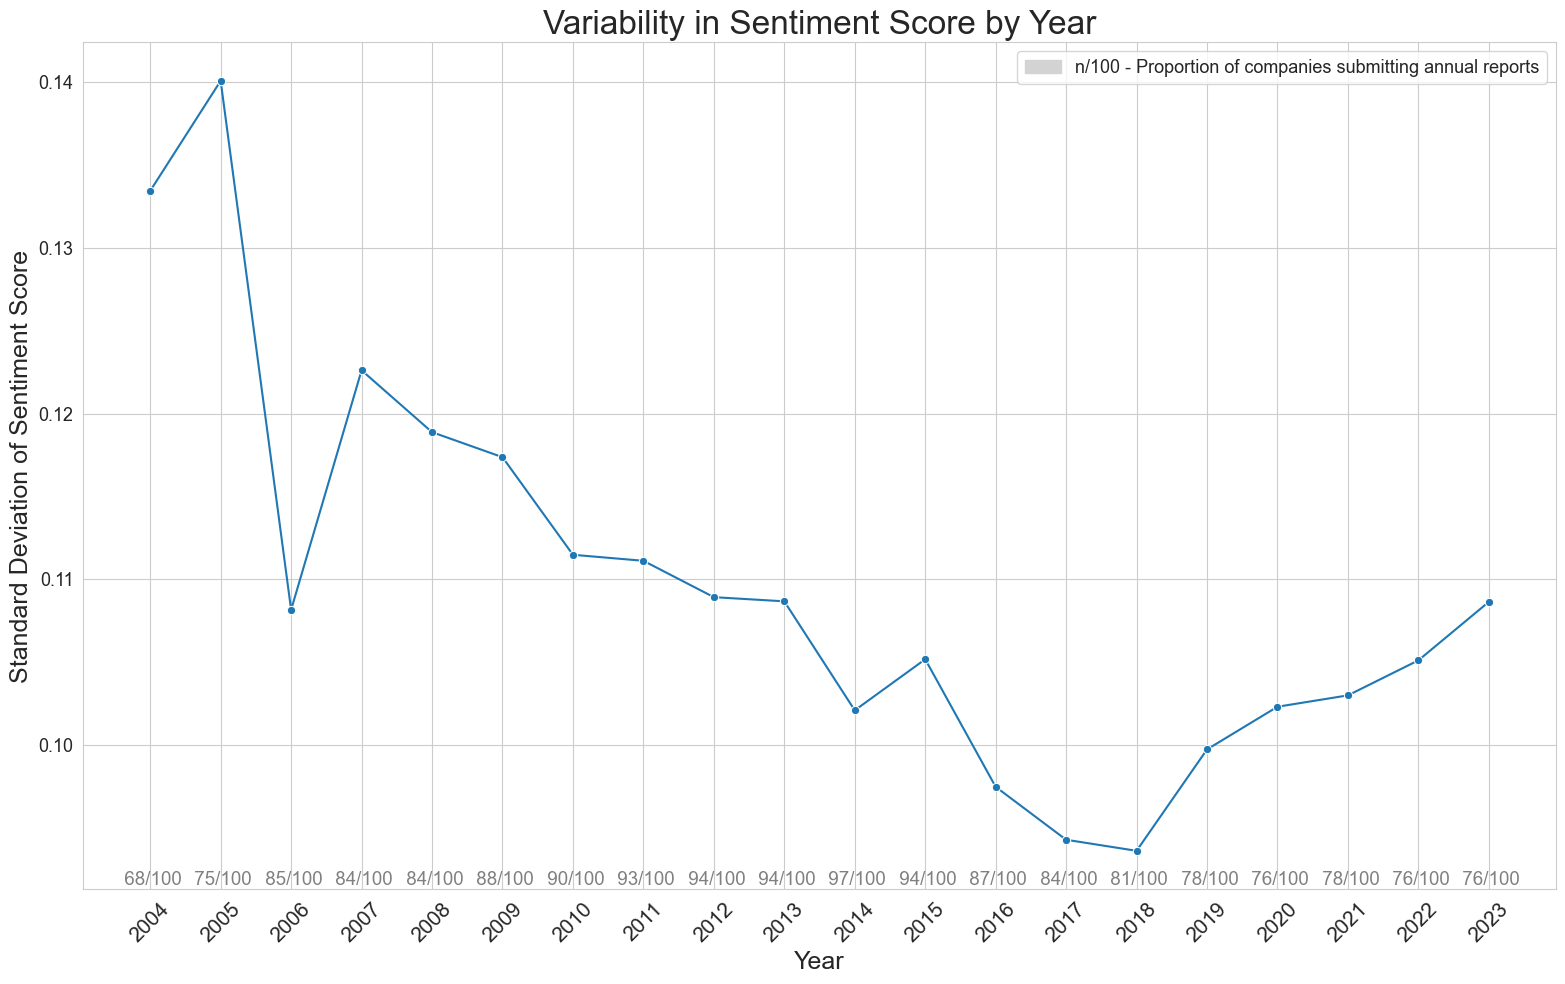

In [17]:
# ------- Calculating the variability of sentiment scores **within each year** -------
yearly_variability = df.groupby('Year')['Sentiment Score'].std().reset_index()
yearly_variability['Year'] = yearly_variability['Year'].astype(int)

# Add 'Company Presence by Year' for annotations
yearly_variability = yearly_variability.merge(df[['Year', 'Company Presence by Year']].drop_duplicates(), on='Year', how='left')

# Plotting the variability of sentiment scores over years
plt.figure(figsize=(19, 11))
sns.set_style("whitegrid")
line_plot = sns.lineplot(x='Year', y='Sentiment Score', data=yearly_variability, marker='o')
plt.title('Variability in Sentiment Score by Year', size=24)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Standard Deviation of Sentiment Score', fontsize=18)
plt.xticks(yearly_variability['Year'], rotation=45, fontsize=15)
plt.yticks(fontsize=13)
plt.grid(True)

# 'Company Presence' annotations below the x-axis
for i, row in average_sentiment_by_year.iterrows():
    plt.text(
        row['Year'],
        plt.gca().get_ylim()[0],
        ' ' + str(row['Company Presence by Year']),
        verticalalignment='bottom',
        horizontalalignment='center',
        color='gray',
        fontsize=13.5
    )

proportion_patch = mpatches.Patch(color='lightgrey', label='n/100 - Proportion of companies submitting annual reports')
plt.legend(handles=[proportion_patch], loc='upper right', fontsize=13)

plt.show()

### Boilerplate Text analysis

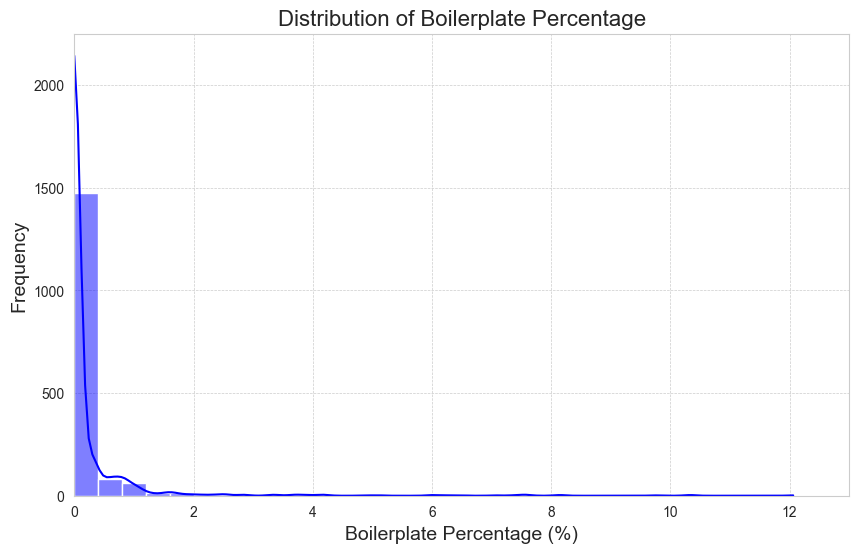

In [18]:
# Creating the plot
plt.figure(figsize=(10, 6))
sns.histplot(df['Boilerplate Percentage'], bins=30, kde=True, color='blue', kde_kws={'bw_adjust':0.5})
plt.title('Distribution of Boilerplate Percentage', fontsize=16)
plt.xlabel('Boilerplate Percentage (%)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(0, 13)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

#### Average Boilerplate Language Over the Years

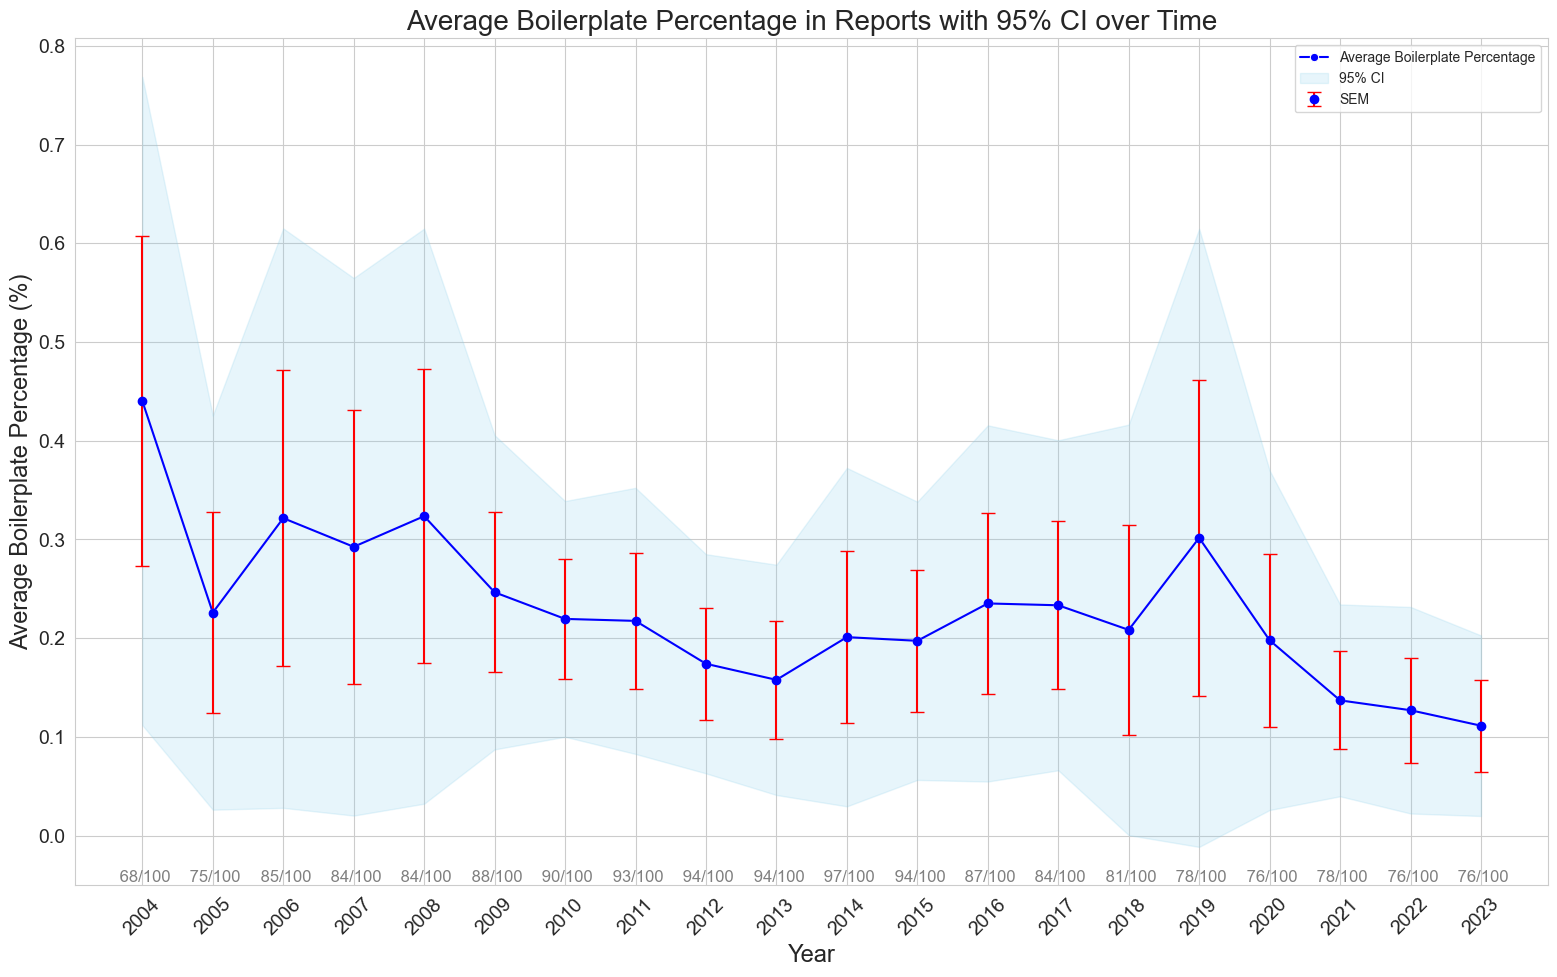

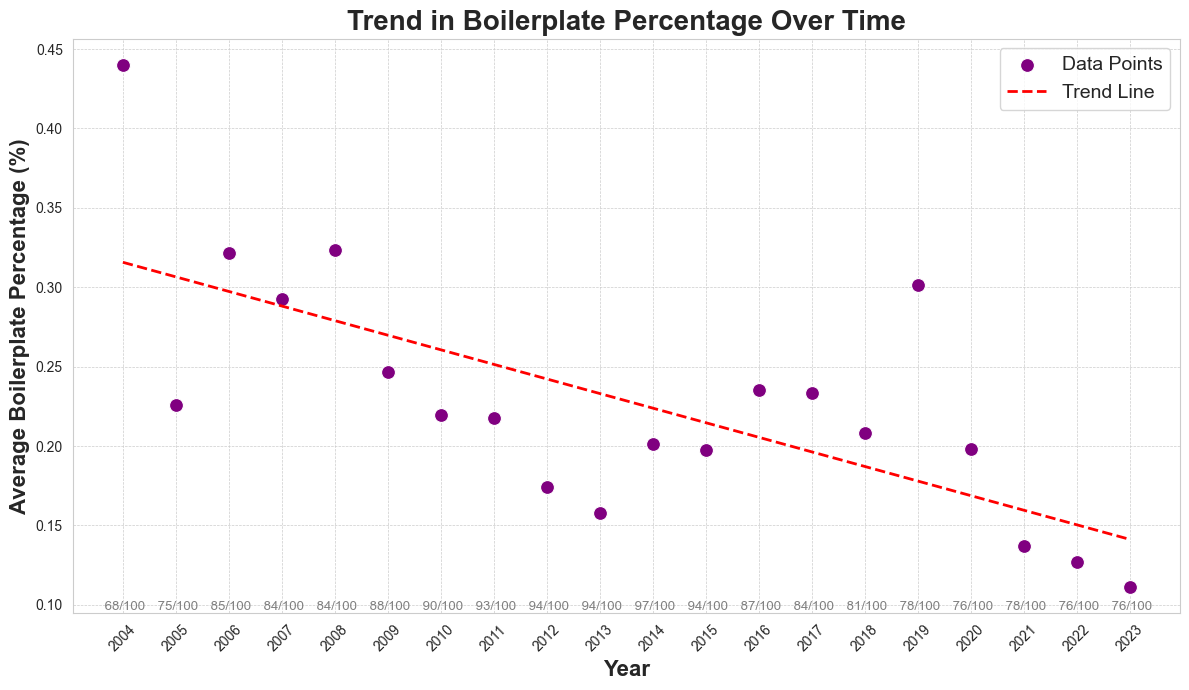

In [19]:
# Calculate mean and SEM per year for Boilerplate Percentage
average_boilerplate_by_year = df.groupby('Year')['Boilerplate Percentage'].mean().reset_index()
average_boilerplate_by_year['SEM'] = df.groupby('Year')['Boilerplate Percentage'].sem().reset_index(drop=True)

# Calculate 95% confidence interval
alpha = 0.05
z_score = np.abs(stats.norm.ppf(1 - alpha / 2))
ci_half_width = z_score * average_boilerplate_by_year['SEM']

# Merge 'Company Presence' data
average_boilerplate_by_year = average_boilerplate_by_year.merge(
    df[['Year', 'Company Presence by Year']].drop_duplicates(),
    on='Year',
    how='left'
)

# Graph settings
plt.figure(figsize=(19, 11))

# Mean line and confidence interval
sns.lineplot(
    data=average_boilerplate_by_year,
    x='Year',
    y='Boilerplate Percentage',
    marker='o',
    color='blue',
    label='Average Boilerplate Percentage'
)
plt.fill_between(
    average_boilerplate_by_year['Year'],
    (average_boilerplate_by_year['Boilerplate Percentage'] - ci_half_width),
    (average_boilerplate_by_year['Boilerplate Percentage'] + ci_half_width),
    alpha=0.2,
    color='skyblue',
    label='95% CI'
)

# SEM bars
plt.errorbar(
    average_boilerplate_by_year['Year'],
    average_boilerplate_by_year['Boilerplate Percentage'],
    yerr=average_boilerplate_by_year['SEM'],
    fmt='o',
    color='blue',
    ecolor='red',
    capsize=5,
    label='SEM'
)

# 'Company Presence' annotations below the x-axis
for i, row in average_boilerplate_by_year.iterrows():
    plt.text(
        row['Year'],
        plt.gca().get_ylim()[0],
        ' ' + str(row['Company Presence by Year']),
        verticalalignment='bottom',
        horizontalalignment='center',
        color='gray',
        fontsize=12
    )

# Labels and title
plt.title('Average Boilerplate Percentage in Reports with 95% CI over Time', fontsize=20)
plt.xlabel('Year', fontsize=17)
plt.ylabel('Average Boilerplate Percentage (%)', fontsize=17)

# Rotation and grid
plt.xticks(average_boilerplate_by_year['Year'], rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

# Legend
plt.legend()

# Display
plt.show()

# Aggregate data by Year
average_boilerplate_by_year = df.groupby('Year')['Boilerplate Percentage'].mean().reset_index()
average_boilerplate_by_year['SEM'] = df.groupby('Year')['Boilerplate Percentage'].sem().reset_index(drop=True)

# Linear Regression to identify trends
X_boilerplate = average_boilerplate_by_year[['Year']]
y_boilerplate = average_boilerplate_by_year['Boilerplate Percentage']
linear_regressor_boilerplate = LinearRegression()
linear_regressor_boilerplate.fit(X_boilerplate, y_boilerplate)
trend_line_boilerplate = linear_regressor_boilerplate.predict(X_boilerplate)

# Merge 'Company Presence' data
average_boilerplate_by_year = average_boilerplate_by_year.merge(
    df[['Year', 'Company Presence by Year']].drop_duplicates(),
    on='Year',
    how='left'
)

# Plot the trend with detailed visualization
plt.figure(figsize=(12, 7))
sns.scatterplot(x='Year', y='Boilerplate Percentage', data=average_boilerplate_by_year, s=100, color='purple', label='Data Points')
plt.plot(average_boilerplate_by_year['Year'], trend_line_boilerplate, color='red', linewidth=2, linestyle='--', label='Trend Line')
plt.title('Trend in Boilerplate Percentage Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Average Boilerplate Percentage (%)', fontsize=16, fontweight='bold')
plt.xticks(np.arange(min(average_boilerplate_by_year['Year']), max(average_boilerplate_by_year['Year']) + 1, 1), rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 'Company Presence' annotations below the x-axis
for i, row in average_boilerplate_by_year.iterrows():
    plt.text(
        row['Year'],
        plt.gca().get_ylim()[0],
        ' ' + str(row['Company Presence by Year']),
        verticalalignment='bottom',
        horizontalalignment='center',
        color='gray',
        fontsize=9.5
    )

plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

#### Annual distribution of Boilerplate Percentage by Company

In [20]:
# Create the boxplot including all companies with hover information
fig = px.box(df, x='Year', y='Boilerplate Percentage', 
             labels={'Boilerplate Percentage': 'Boilerplate Percentage (%)'},
             hover_data=['Company'],
             title='Annual Distribution of Boilerplate Percentage by Company')

# Update plot appearance
fig.update_traces(marker=dict(color='blue'))
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Boilerplate Percentage (%)',
    plot_bgcolor='white',
    showlegend=False
)

# Add grid lines for better readability
fig.update_xaxes(showline=True, linewidth=2, linecolor='gray', gridcolor='lightgray', tickmode='linear', dtick=1)

fig.update_yaxes(showline=True, linewidth=2, linecolor='gray', gridcolor='lightgray', dtick=1)

fig.write_html("boilerplate_percentage_plot.html")
fig.show()

# Calculate the mean boilerplate percentage for each company
avg_boilerplate = df.groupby('Company')['Boilerplate Percentage'].mean().sort_values(ascending=False)

# Identify the top 5 companies
top_5_companies = avg_boilerplate.head(5).index.tolist()

# Function to plot data for selected companies
def plot_data(selected_companies):
    global fig  # Make fig a global variable so it can be accessed by the save function
    fig = go.Figure()

    if not selected_companies:
        selected_companies = top_5_companies
    
    max_boilerplate_percentage = 0
    company_names = []

    for company in selected_companies:
        company_data = df[df['Company'] == company].sort_values('Year')
        current_max = company_data['Boilerplate Percentage'].max()
        if current_max > max_boilerplate_percentage:
            max_boilerplate_percentage = current_max

        fig.add_trace(go.Scatter(
            x=company_data['Year'],
            y=company_data['Boilerplate Percentage'],
            mode='lines+markers',
            name=company,
            hoverinfo='all'
        ))

        company_names.append(company)

    title_text = f"Boilerplate Percentage Time Series for {' & '.join(company_names)}" if company_names else "Select a Company"

    fig.update_layout(
        title=title_text,
        xaxis_title='Year',
        yaxis_title='Boilerplate Percentage (%)',
        legend_title='Company',
        hovermode='closest',
        plot_bgcolor='white',
        xaxis=dict(
            tickmode='linear',
            dtick=1,
            showline=True,
            showgrid=True,
            linecolor='gray',
            gridcolor='lightgray'
        ),
        yaxis=dict(
            showline=True,
            showgrid=True,
            linecolor='gray',
            gridcolor='lightgray'
        ),
        font=dict(
            family="Arial, sans-serif",
            size=12,
            color="black"
        )
    )

    fig.show()

# Function to save the plot
def save_plot(_):
    if not company_dropdown.value:
        filename = 'boilerplate_percentage_top_5_companies.html'
    else:
        company_names = '_'.join(company_dropdown.value).replace(' ', '_')
        filename = f'boilerplate_percentage_time_series_for_{company_names}.html'
    fig.write_html(filename)
    print(f'Plot saved as {filename}')

# Dropdown for selecting the company with multiple selections enabled
company_dropdown = widgets.SelectMultiple(
    options=sorted(df['Company'].unique()),
    value=top_5_companies,
    description='Company:',
    disabled=False
)

# Save button
save_button = Button(description="Save Plot")
save_button.on_click(save_plot)

# Combine the dropdown and button in a layout
ui = VBox([company_dropdown, save_button])

# Bind the plotting function to the dropdown widget
interact(plot_data, selected_companies=company_dropdown)

# Display the UI
display(ui)

####### In order to select multiple companies at the same time -> hold CTRL + left mouse click #######



interactive(children=(SelectMultiple(description='Company:', index=(52, 84, 19, 25, 82), options=('ABBVIE INC'…

### Most Frequent Words

#### Word Cloud for selected companies

Dropdown(description='Company:', index=9, options=('ABBVIE INC', 'ACCENTURE PLC', 'ADOBE INC', 'ADT CORP', 'AF…

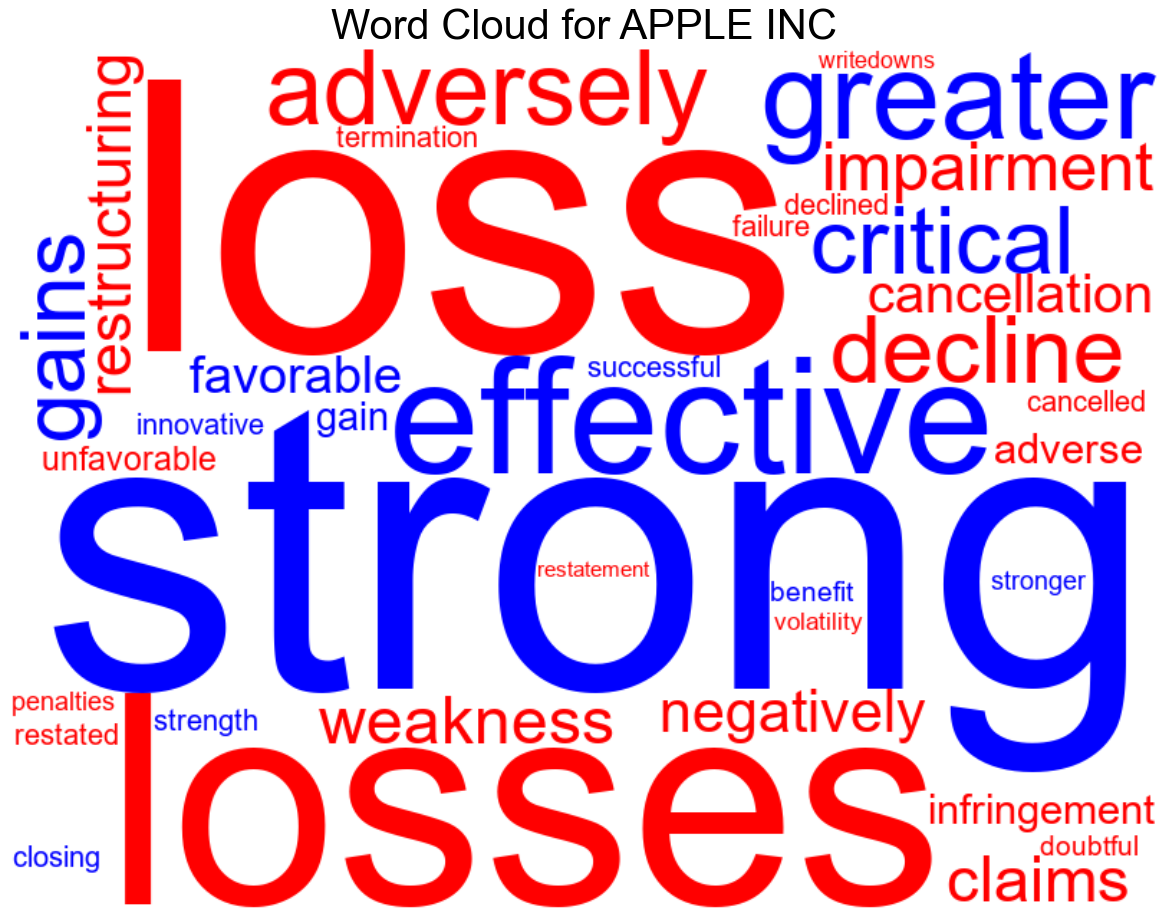

In [21]:
## We must reload the libraries and Dictionaries
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import ast
import ipywidgets as widgets
from IPython.display import display

# Load the Loughran-McDonald dictionary
lm_dictionary_path = 'C:/Users/alfre/OneDrive/Desktop/tesi/pycode/Loughran-McDonald_MasterDictionary_1993-2023.csv'
lm_dict = pd.read_csv(lm_dictionary_path)
positive_words = set(lm_dict[lm_dict['Positive'] > 0]['Word'].str.lower())
negative_words = set(lm_dict[lm_dict['Negative'] > 0]['Word'].str.lower())

# Function to avoid parsing errors
def parse_key_words(row):
    if isinstance(row, str):
        try:
            return ast.literal_eval(row)
        except:
            return []
    return row

df['Key Sentiment Words'] = df['Key Sentiment Words'].apply(parse_key_words)

# Function to aggregate sentiment words for each company
def aggregate_sentiment_words(df):
    aggregated_words = {}
    for _, row in df.iterrows():
        company = row['Company']
        key_words = row['Key Sentiment Words']
        if company not in aggregated_words:
            aggregated_words[company] = Counter()
        for word, count in key_words:
            aggregated_words[company][word] += count
    return aggregated_words

aggregated_words = aggregate_sentiment_words(df)

# Function to generate and display a word cloud
def generate_word_cloud(words, company, min_word_count=25):
    if len(words) >= min_word_count:
        wordcloud = WordCloud(width=800, height=600,
                              background_color='white',
                              colormap='cool',
                              min_font_size=15,
                              max_words=50,
                              collocations=False,
                              color_func=lambda *args, **kwargs: 'red' if args[0] in negative_words else 'blue',
                              font_path='arial.ttf'
                              ).generate_from_frequencies(words)

        plt.figure(figsize=(16, 9))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title(f"Word Cloud for {company}", fontsize=30, color='black')
        plt.axis("off")
        plt.tight_layout(pad=0)
        plt.show()
    else:
        print(f"Not enough words to generate word cloud for {company}")

# Function to handle company selection and generate word cloud
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        company = change['new']
        if company in aggregated_words:
            generate_word_cloud(aggregated_words[company], company)
        else:
            print(f"No words found for company {company}")

# Dropdown to select a company, with "Apple Inc" as the default value
dropdown = widgets.Dropdown(
    options=sorted(aggregated_words.keys()),
    description='Company:',
    value='APPLE INC',  # Set default value to 'APPLE INC'
    disabled=False
)

dropdown.observe(on_change)

# Display the dropdown
display(dropdown)

# Generate word cloud for the default selected company
generate_word_cloud(aggregated_words['APPLE INC'], 'APPLE INC')


## Predictive Models

### Boilerplate Percentage Prediction

16:10:45 - cmdstanpy - INFO - Chain [1] start processing
16:10:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 0.0024305561780311054
R^2 Score: 0.5809562272043931

Future Predictions:
Year: 2024, Predicted Boilerplate Percentage: 0.17752798804598424
Year: 2025, Predicted Boilerplate Percentage: 0.18882335793102503
Year: 2026, Predicted Boilerplate Percentage: 0.19974640020514822
Year: 2027, Predicted Boilerplate Percentage: 0.21027310784980968


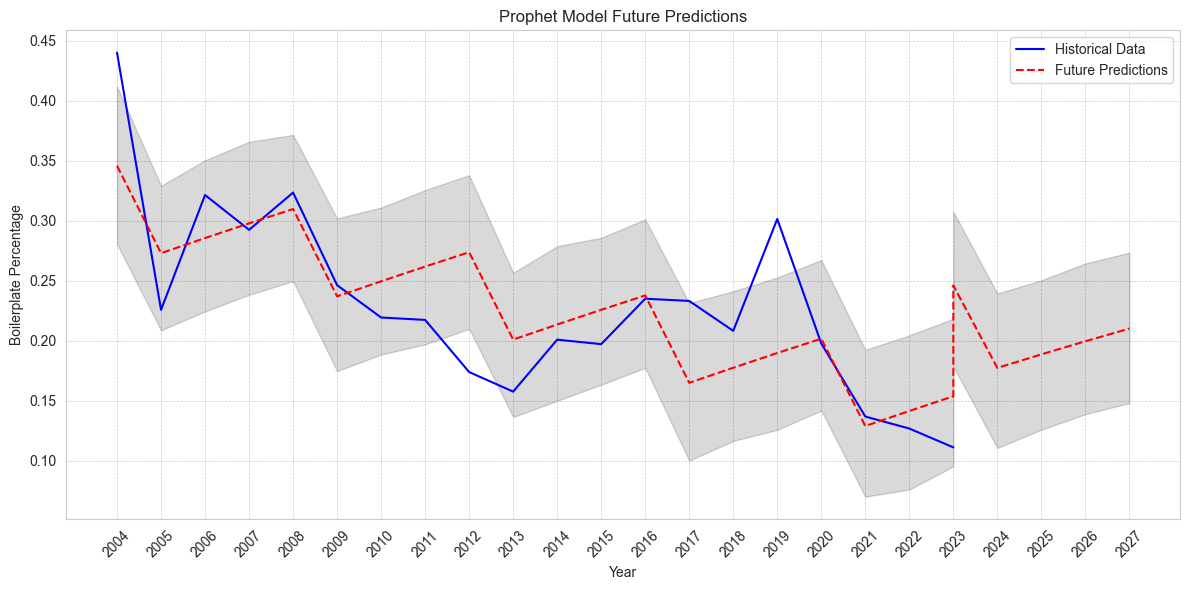

In [22]:
# Create a new DataFrame for modifications
df1 = df.copy()

# Aggregate data by Year
df1_agg = df1.groupby('Year').agg({
    'Boilerplate Percentage': 'mean'
}).reset_index()

# Rename columns for Prophet
df1_agg.rename(columns={'Year': 'ds', 'Boilerplate Percentage': 'y'}, inplace=True)

# Convert 'ds' to datetime format for compatibility with Prophet
df1_agg['ds'] = pd.to_datetime(df1_agg['ds'], format='%Y')

# Initialize and fit the model
model = Prophet()
model.fit(df1_agg)

# Make future predictions for the next 5 years
future = model.make_future_dataframe(periods=5, freq='Y')
forecast = model.predict(future)

# Ensure the historical DataFrame only includes data up to 2023
historical = forecast[forecast['ds'] <= '2023-12-31']

# Merge the historical predictions back with the actual data
merged = pd.merge(df1_agg, historical[['ds', 'yhat']], on='ds', how='left')

# Evaluate the model on historical data
mse = mean_squared_error(merged['y'], merged['yhat'])
r2 = r2_score(merged['y'], merged['yhat'])

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Print the future predictions
future_predictions = forecast[forecast['ds'] > '2023-12-31']
print("\nFuture Predictions:")
for _, row in future_predictions.iterrows():
    print(f"Year: {row['ds'].year}, Predicted Boilerplate Percentage: {row['yhat']}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(merged['ds'].dt.year, merged['y'], label='Historical Data', color='blue')
plt.plot(forecast['ds'].dt.year, forecast['yhat'], label='Future Predictions', color='red', linestyle='--')
plt.fill_between(forecast['ds'].dt.year, forecast['yhat_lower'], forecast['yhat_upper'], color='k', alpha=.15)

# Enhance the plot
plt.xlabel('Year')
plt.ylabel('Boilerplate Percentage')
plt.title('Prophet Model Future Predictions')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.xticks(np.arange(min(merged['ds'].dt.year), max(forecast['ds'].dt.year) + 1), rotation=45)
plt.tight_layout()
plt.show()
